In [1]:
%load_ext autoreload
%autoreload 2

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import glob
from kcwi_util_modified import register_sauron_colormap
from kcwi_util_modified import visualization
from kcwi_util_modified import get_datacube
from kcwi_util_modified import ppxf_kinematics_RXJ1131_getGlobal_lens_deredshift
from kcwi_util_modified import remove_quasar_from_galaxy_deredshift
from kcwi_util_modified import find_nearest
from kcwi_util_modified import SN_CaHK
from kcwi_util_modified import select_region
from kcwi_util_modified import voronoi_binning
from kcwi_util_modified import get_voronoi_binning_data
from kcwi_util_modified import get_velocity_dispersion_deredshift
from kcwi_util_modified import kinematics_map
from kcwi_util_modified import stellar_type
from vorbin.voronoi_2d_binning import voronoi_2d_binning
import pandas as pd

from specim.specfuncs import spec1d
register_sauron_colormap()

In [2]:
import ppxf

In [3]:
ppxf.__version__

'8.1.0'

### The lens spectra is extracted summing the light with a circular aperture of radius 0.5 arcsec. The quasar spectra are from the brightest pixels in image A, B and C.

In [4]:
libary_dir = '../../kcwi_extractions/all_dr2_fits'

#data directory
dir = "../../kcwi_extractions/extracted_dispersions/"

#KCWI mosaic datacube
name = "KCWI_RXJ1131_icubes_mosaic_0.1457"

#spectrum from the lens center
#spectrum_aperture1 = dir + 'lens.fits' # single pixel
spectrum_aperture = dir + 'lens_central_area.fits' # pixels containing an area with radius 0.5 arcsec


#spectrum from the quasar center
quasar_spectrum_A  = dir + 'quasar_A.fits'
quasar_spectrum_B  = dir + 'quasar_B.fits'
quasar_spectrum_C  = dir + 'quasar_C.fits'

#redshift of the lens
z = 0.295
## R=3600. spectral resolution is ~ 1.42 using observed wavelength 5115 (restframe 3950 Ang) 
FWHM_gal = 1.42
FWHM_tem_xshooter = 0.41 ## R=9700 and wavelength 5115/(1+z) or 3949.81 Ang
noise = 0.014 ## initial estimate of the noise
degree = 3 # degree of the additive Legendre polynomial in ppxf
T_exp = 266 * 60 # the exposure time in second for the KCWI datasets.
wave_min = 0.34  # restframe wavelength in micrometer
wave_max = 0.43
velscale_ratio = 2

### Check the spectra

In [5]:
lens_sp = spec1d.Spec1d(spectrum_aperture, informat='fitsflux', trimsec=[2150, -735])


Reading spectrum from ../../kcwi_extractions/extracted_dispersions/lens_central_area.fits
Expected file format: fitsflux
 Spectrum Start:  4404.00
 Spectrum End:     5568.50
 Dispersion (1st pixel):   0.50
 Dispersion (average):      0.50




Line        lambda_rest  lambda_obs
----------  -----------  -----------
H-kappa       3750.00       4856.25
[Fe VII]      3761.40       4871.01
H-iota        3770.00       4882.15
H-theta       3797.00       4917.11
H-eta         3835.00       4966.32
CN bandhd     3883.00       5028.48
CaII K        3933.67       5094.10
CaII H        3968.47       5139.17
H-delta       4101.00       5310.80



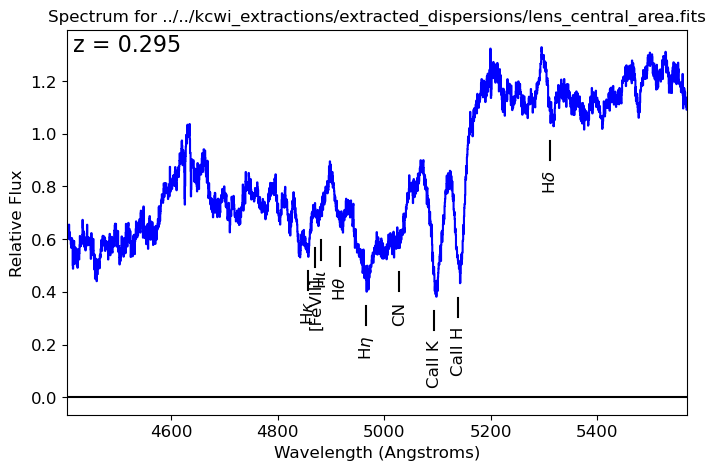

In [6]:
fg = plt.figure(figsize=(8, 5))
lens_sp.smooth(1, fig=fg)
lens_sp.mark_lines('abs', z=0.295, usesmooth=True)

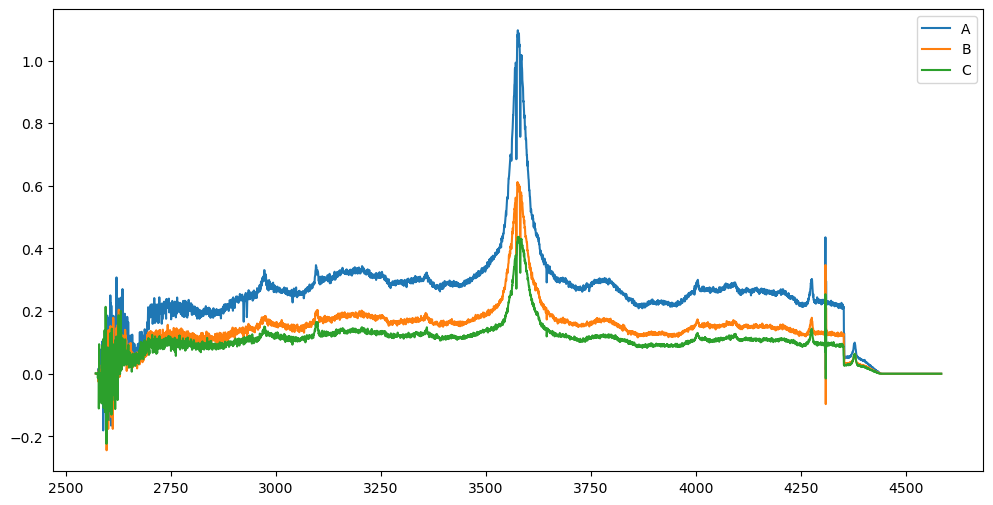

In [7]:
plt.figure(figsize=(12, 6))
hd = fits.open(quasar_spectrum_A)[0].header
wv = (hd['CRVAL1'] + np.arange(hd['NAXIS1'])* hd['CDELT1'])/(1.295) # restframed in lens redshift
plt.plot(wv, fits.open(quasar_spectrum_A)[0].data, label='A')
plt.plot(wv, fits.open(quasar_spectrum_B)[0].data, label="B")
plt.plot(wv, fits.open(quasar_spectrum_C)[0].data, label="C")
plt.legend()

### Create three global lens template from the full librray (628 stellar templates covering the 'UVB' region of around 529 different stars). These three global templates consist of completely non-overlaping set of stellar templates.

### global_temp1 would be used for kinematics measurement and other two global templates are to calculate systematic uncertainty

In [8]:
temp_all = glob.glob(libary_dir + '/*uvb.fits')

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
FWHM_gal= 1.0965250965250966
FWHM_tem= 0.41
[1386 1387 1388 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       229       279
chi2/DOF: 2.348; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 39/629
Formal errors:
     dV    dsigma   dh3      dh4
      13     5.2
Elapsed time in pPXF: 2.23 s


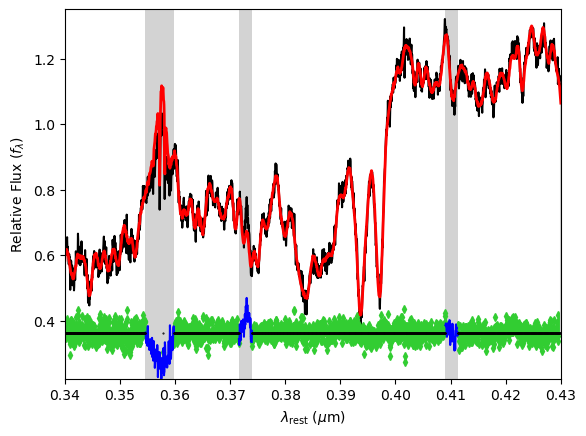

In [9]:
templates1, pp1, lamRange1, logLam1, lamRange2, logLam2, galaxy1, quasar1 = \
    ppxf_kinematics_RXJ1131_getGlobal_lens_deredshift(libary_dir,
                                                      degree=degree,
                                                      spectrum_aperture=spectrum_aperture,
                                                      wave_min=wave_min,
                                                      wave_max=wave_max,
                                                      velscale_ratio=velscale_ratio,
                                                      z=z,
                                                      noise=noise,
                                                      templates_name='xshooter',
                                                      FWHM=FWHM_gal,
                                                      FWHM_tem=FWHM_tem_xshooter,
                                                      quasar_spectrum=quasar_spectrum_A,
                                                      plot=True, temp_array=temp_all)
nTemplates1 = templates1.shape[1]
global_temp1 = templates1 @ pp1.weights[:nTemplates1]

In [10]:
m = pp1.weights[:nTemplates1] >0
tmp = np.array(temp_all)[m]

sorted(tmp)

['../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0072_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0123_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0137_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0172_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0246_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0257_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0263_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0273_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0276_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0401_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0405_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0406_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0419_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0428_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectr

In [11]:
# m = pp1.weights[:nTemplates1] >0
# tmp = np.array(temp_all)[m]
# tmp_set_1 = sorted(tmp)

choice = np.random.choice(range(len(temp_all)), size=int(len(temp_all)/2), replace=False)    
first_set = np.zeros(len(temp_all), dtype=bool)
first_set[choice] = True
second_set = ~first_set

tmp_set_1 = np.array(temp_all)[first_set]

In [12]:
temp_set_new = tmp_set_1

# for fl in temp_all:
#     if fl in tmp_set_1:
#         pass
#     else:
#         temp_set_new.append(fl)
len(temp_set_new)

314

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.150146484375
velscale of the templates is [16.62743718]
FWHM_gal= 1.0965250965250966
FWHM_tem= 0.41
[1378 1379 1380 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       521       278
chi2/DOF: 2.419; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 8; Func calls: 26; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 31/315
Formal errors:
     dV    dsigma   dh3      dh4
     9.8       5
Elapsed time in pPXF: 1.55 s


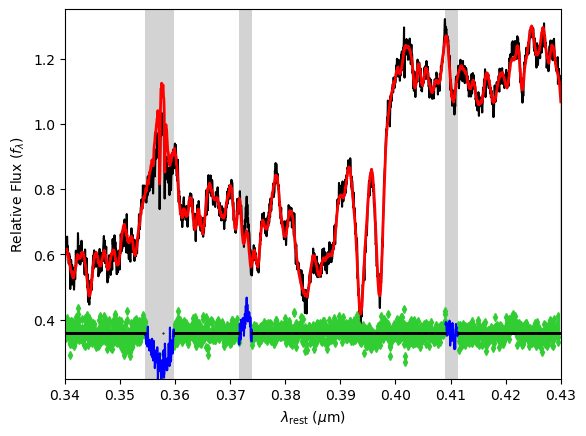

In [13]:
templates2, pp2, lamRange1, logLam1, lamRange2, logLam2, galaxy1, quasar1 = \
    ppxf_kinematics_RXJ1131_getGlobal_lens_deredshift(libary_dir,
                                                      degree=degree,
                                                      spectrum_aperture=spectrum_aperture,
                                                      wave_min=wave_min,
                                                      wave_max=wave_max,
                                                      velscale_ratio=velscale_ratio,
                                                      z=z,
                                                      noise=noise,
                                                      templates_name='xshooter',
                                                      FWHM=FWHM_gal,
                                                      FWHM_tem=FWHM_tem_xshooter,
                                                      quasar_spectrum=quasar_spectrum_A,
                                                      plot=True, temp_array=temp_set_new)
nTemplates2 = templates2.shape[1]
global_temp2 = templates2 @ pp2.weights[:nTemplates2]

In [14]:
m2 = pp2.weights[:nTemplates2] >0
tmp1 = np.array(temp_set_new)[m2]

sorted(tmp1)

['../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0026_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0072_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0123_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0172_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0199_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0246_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0257_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0260_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0263_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0279_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0401_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0458_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0487_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0511_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectr

In [15]:
# sorted(tmp1)
tmp_set_2 = np.array(temp_all)[second_set]

len(tmp_set_2)

314

In [16]:
temp_set_new2 = tmp_set_2 #[]
# for fl in temp_all:
#     if fl in tmp_set_1 or fl in tmp1:
#         pass
#     else:
#         temp_set_new2.append(fl)
len(temp_set_new2)

314

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
FWHM_gal= 1.0965250965250966
FWHM_tem= 0.41
[1386 1387 1388 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       240       292
chi2/DOF: 2.438; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 32/315
Formal errors:
     dV    dsigma   dh3      dh4
     9.9     4.6
Elapsed time in pPXF: 1.08 s


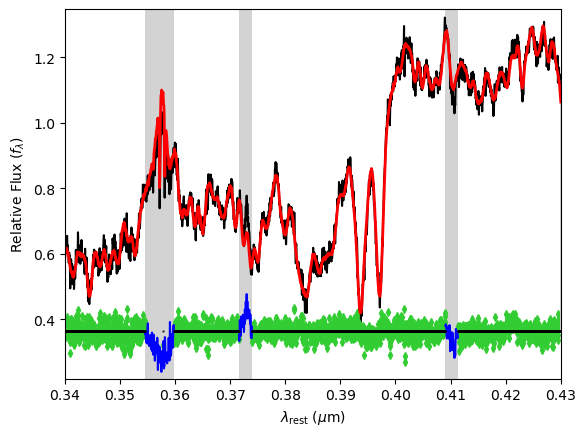

In [17]:
templates3, pp3, lamRange1, logLam1, lamRange2, logLam2, galaxy1, quasar1 = \
    ppxf_kinematics_RXJ1131_getGlobal_lens_deredshift(libary_dir,
                                                      degree=degree,
                                                      spectrum_aperture=spectrum_aperture,
                                                      wave_min=wave_min,
                                                      wave_max=wave_max,
                                                      velscale_ratio=velscale_ratio,
                                                      z=z,
                                                      noise=noise,
                                                      templates_name='xshooter',
                                                      FWHM=FWHM_gal,
                                                      FWHM_tem=FWHM_tem_xshooter,
                                                      quasar_spectrum=quasar_spectrum_A,
                                                      plot=True, temp_array=temp_set_new2)
nTemplates3 = templates3.shape[1]
global_temp3 = templates3 @ pp3.weights[:nTemplates3]

In [18]:
m3 = pp3.weights[:nTemplates3] >0
tmp2 = np.array(temp_set_new2)[m3]
sorted(tmp2)

['../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0205_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0220_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0273_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0276_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0282_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0352_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0397_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0406_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0419_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0428_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0430_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0435_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0436_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0438_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectr

In [19]:
len(temp_all)

628

In [20]:
df = pd.DataFrame({'weight': pp1.weights[:nTemplates1][m],
                   'names': tmp}
                  )
df.to_csv('template_set_1.csv', index=False)

df = pd.DataFrame({'weight': pp2.weights[:nTemplates2][m2],
                   'names': tmp1}
                  )
df.to_csv('template_set_2.csv', index=False)

df = pd.DataFrame({'weight': pp3.weights[:nTemplates3][m3],
                   'names': tmp2}
                  )
df.to_csv('template_set_3.csv', index=False)

df = pd.DataFrame({'weight': np.ones(len(temp_all))/np.float(len(temp_all)),
                   'names': temp_all}
                  )
df.to_csv('template_set_all.csv', index=False)

/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_49328/2482505990.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df = pd.DataFrame({'weight': np.ones(len(temp_all))/np.float(len(temp_all)),


### Check whether the global templates are completely non-overlaping

In [21]:
set(tmp).intersection(set(tmp)), set(tmp).intersection(set(tmp1)), set(tmp).intersection(set(tmp2))

({'../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0072_uvb.fits',
  '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0123_uvb.fits',
  '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0137_uvb.fits',
  '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0172_uvb.fits',
  '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0246_uvb.fits',
  '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0257_uvb.fits',
  '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0263_uvb.fits',
  '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0273_uvb.fits',
  '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0276_uvb.fits',
  '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0401_uvb.fits',
  '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0405_uvb.fits',
  '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0406_uvb.fits',
  '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0419_uvb.fits',
  '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0428_uvb.fits',
  '../../kcwi_extractions/all_dr2_

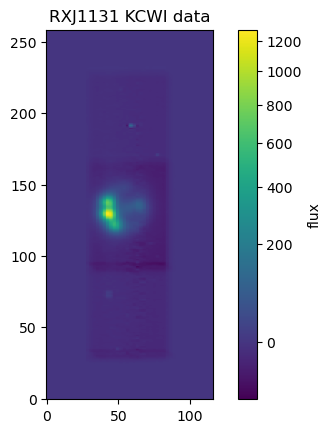

In [22]:
hdu = fits.open(dir+name+'.fits')
visualization(hdu)

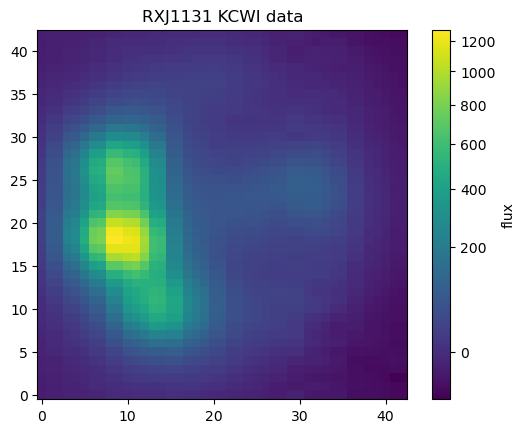

In [23]:
%matplotlib inline

data_crop = fits.open(dir + name + '_crop.fits')
radius_in_pixels = 21
visualization(data_crop)

In [24]:
# image_x = [9, 9, 13, 30, 33]
# image_y = [18, 26, 11, 24, 25]

image_x = np.array([ 9.75440985,  9.48673655, 13.71460203, 31.1065032 ])
image_y = np.array([18.52632387, 26.63888393, 10.89420307, 24.53867802])

sat_x, sat_y = 22.687151464094285, 25.89937713647318
gal_x, gal_y = 23.29113224652393, 22.227448516020196

/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_49328/2084253364.py:1: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(np.sum(data_crop[0].data, axis=0)), origin='lower');


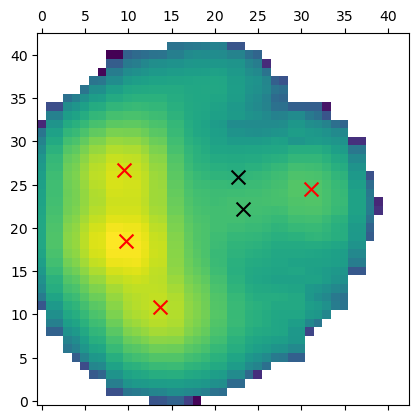

In [25]:
plt.matshow(np.log10(np.sum(data_crop[0].data, axis=0)), origin='lower');
plt.scatter(image_x, image_y, s=100, c='r', marker='x')
plt.scatter(sat_x, sat_y, s=100, c='k', marker='x')
plt.scatter(gal_x, gal_y, s=100, c='k', marker='x');


### loop over the entire cropped data cube to remove the quasar and obtain the noise cube using global_template_1

/Users/ajshajib/miniforge3/lib/python3.10/site-packages/ppxf/capfit.py:898: RuntimeWarning: invalid value encountered in double_scalars
  ratio = actred/prered


CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008558; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0  0.000542
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.009015; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00162
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.007957; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0         0
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.005452; DOF: 1884; degree 

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.005990; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0  0.000639
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.009400; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00215
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.005022; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0         0
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

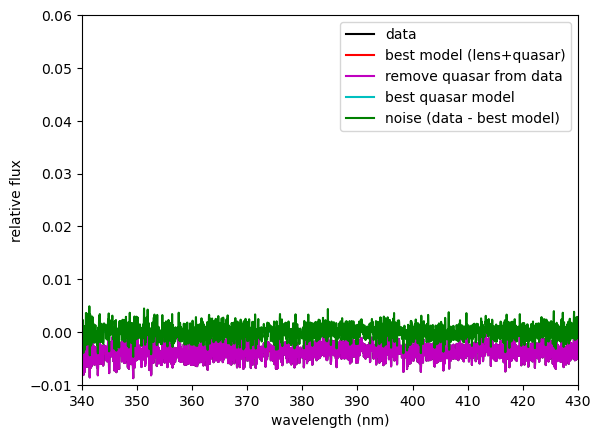

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008003; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0  3.66e-05
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s


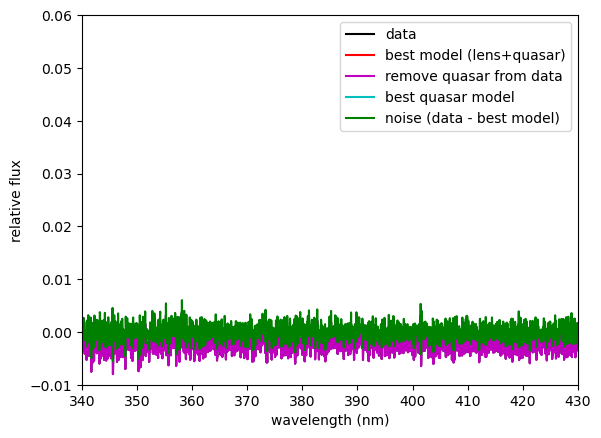

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008533; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0  0.000609
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.009078; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00433
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.006734; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   1.4e-05
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

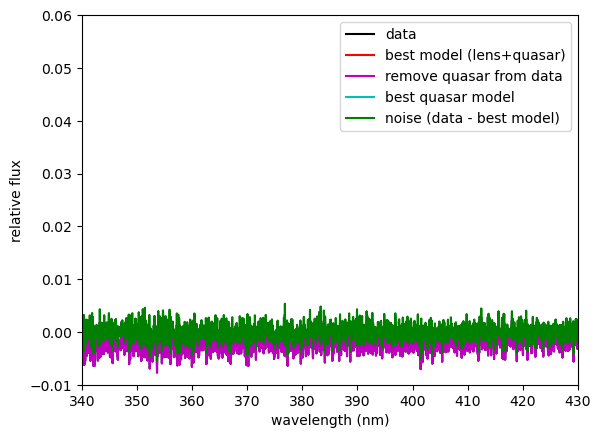

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008642; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0         0
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       -17       370
chi2/DOF: 0.008066; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  4.13e-05  0.000855
Formal errors:
     dV    dsigma   dh3      dh4
 7.2e+03 7.6e+02
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.01041; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00741
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.01092; DOF: 1884; degree = 

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008052; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0         0
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.009185; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00124
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

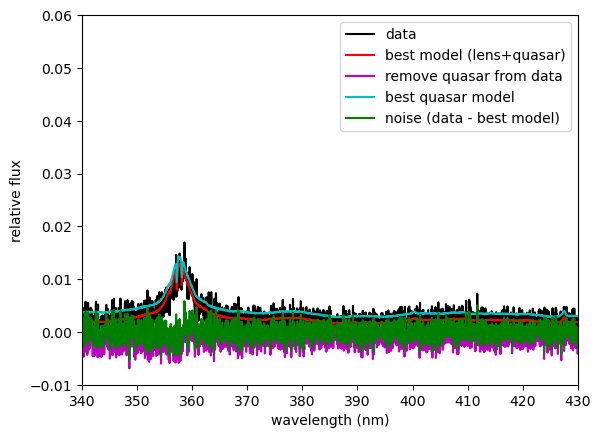

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.01021; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0    0.0058
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:  

velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.01005; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00153
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.007140; DOF: 1884; degree = 3; mdegree = 0
method

 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008313; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0         0
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008313; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0         0
Formal errors:
     dV    dsigma   dh3      dh4
       

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008953; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00466
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.01101; DOF: 1884; degree =

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:        -6        72
chi2/DOF: 0.009077; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 18; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000276  0.000546
Formal errors:
     dV    dsigma   dh3      dh4
      95 7.3e+03
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.006121; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0         0
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008736; DOF: 1884; degree 

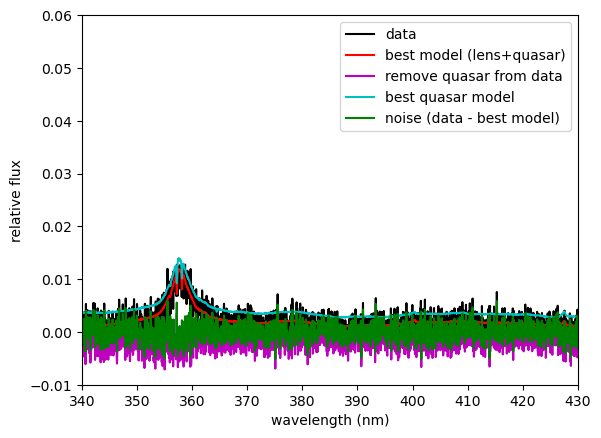

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.005961; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00437
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.01075; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00495
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:  

velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.006928; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0         0
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:        62       239
chi2/DOF: 0.008316; DOF: 1882; degree = 3; mdegree = 0
metho

 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.006699; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00601
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.01068; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00843
Formal errors:
     dV    dsigma   dh3      dh4
       0

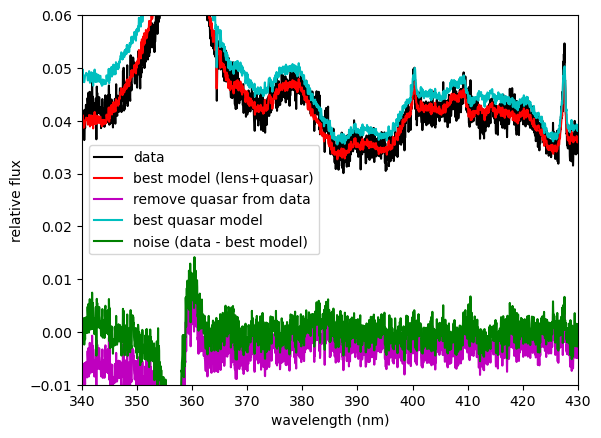

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.05962; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0    0.0564
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:  

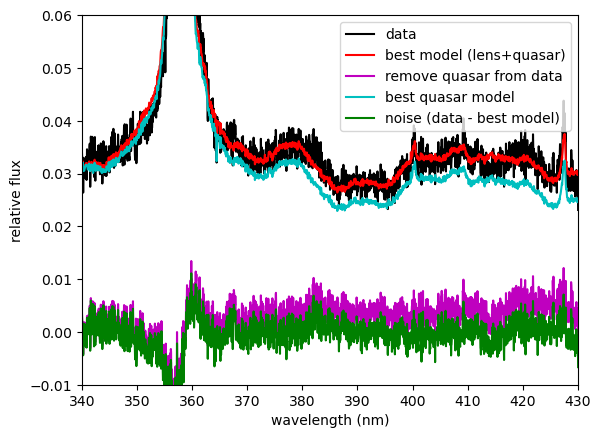

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.02280; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0     0.021
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:  

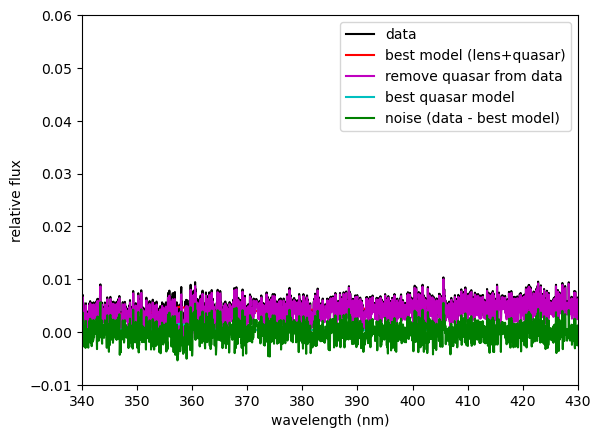

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008666; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0  0.000304
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008855; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00149
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.08097; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0    0.0706
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
c

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.01015; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0         0
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.01015; DOF: 1884; degree = 

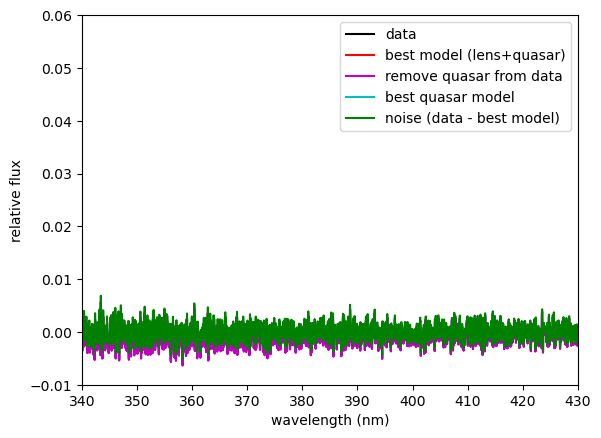

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.007405; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0  7.78e-05
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.02535; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0    0.0342
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.02535; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Stat

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:        58       114
chi2/DOF: 0.01322; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 21; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000596   0.00895
Formal errors:
     dV    dsigma   dh3      dh4
 1.9e+02 2.2e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       178         0
chi2/DOF: 0.01243; DOF: 1882; degree =

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008890; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00025
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.01079; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00877
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008083; DOF: 1884; degree = 3; mdegree = 0
method

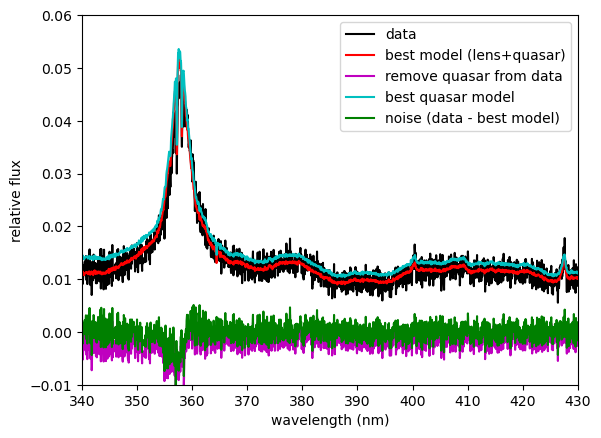

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.01422; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0    0.0188
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:  

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       229         0
chi2/DOF: 0.01242; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 22; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000941   0.00369
Formal errors:
     dV    dsigma   dh3      dh4
      32 2.3e+03
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:      -553         0
chi2/DOF: 0.008458; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
  0.000372         0
Formal errors:
     dV    dsigma   dh3      dh4
      65 3.6e+03
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:      -551         0
chi2/DOF: 0.007094; DOF: 1882; degree

 Best Fit:       Vel     sigma
 comp.  0:       608         0
chi2/DOF: 0.01587; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 8; Func calls: 26; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000605    0.0228
Formal errors:
     dV    dsigma   dh3      dh4
      56   4e+03
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.01511; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0    0.0248
Formal errors:
     dV    dsigma   dh3      dh4
       0

 Best Fit:       Vel     sigma
 comp.  0:       -46       177
chi2/DOF: 0.01240; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00129   0.00393
Formal errors:
     dV    dsigma   dh3      dh4
 1.2e+02 1.3e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       -27       248
chi2/DOF: 0.008758; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00162   0.00237
Formal errors:
     dV    dsigma   dh3      dh4
   1e+0

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008421; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  4.68e-06  0.000122
Formal errors:
     dV    dsigma   dh3      dh4
 3.4e+04 5.4e+03
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

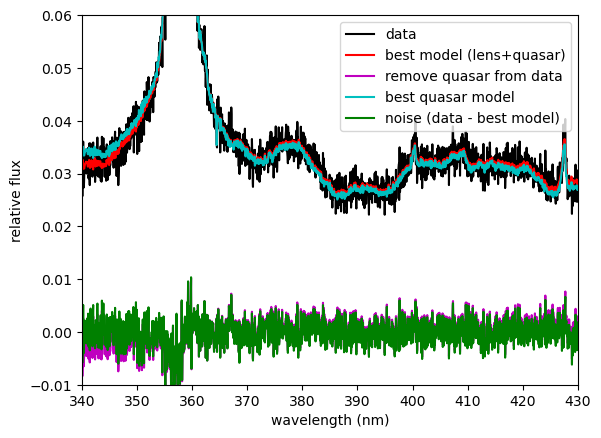

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.03529; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0    0.0575
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s


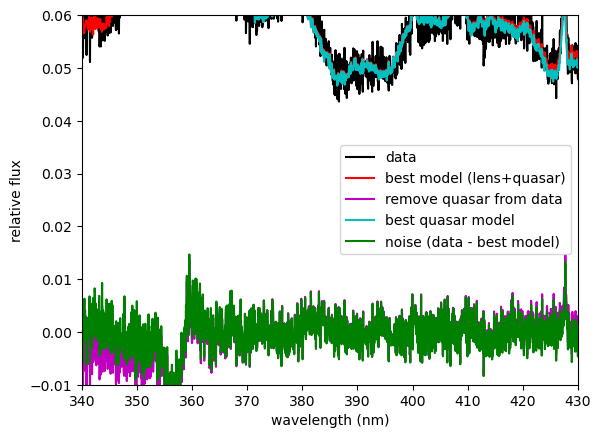

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.03529; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0    0.0575
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:  

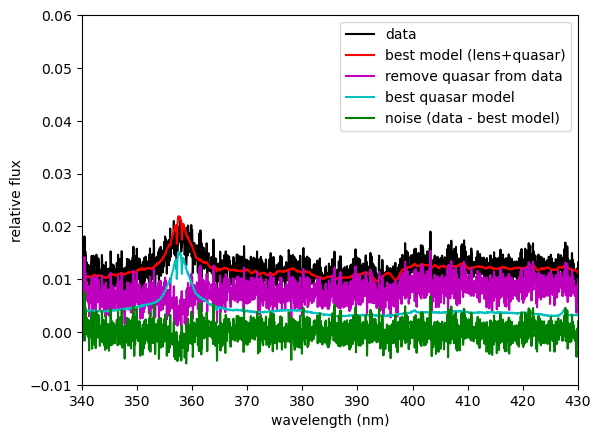

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:        92       188
chi2/DOF: 0.008279; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00275   0.00237
Formal errors:
     dV    dsigma   dh3      dh4
      46      50
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       394         0
chi2/DOF: 0.008606; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 20; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000465  5.81e-07
Formal errors:
     dV    dsigma   dh3      dh4
      53 3.8e+03
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:

 Best Fit:       Vel     sigma
 comp.  0:       174         0
chi2/DOF: 0.02338; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 8; Func calls: 32; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000869    0.0392
Formal errors:
     dV    dsigma   dh3      dh4
      47 2.9e+03
Elapsed time in pPXF: 0.03 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       172         0
chi2/DOF: 0.02234; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 30; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000749    0.0415
Formal errors:
     dV    dsigma   dh3      dh4
      5

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:        81       146
chi2/DOF: 0.01317; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 24; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00185    0.0201
Formal errors:
     dV    dsigma   dh3      dh4
      71      81
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:      -127        78
chi2/DOF: 0.006196; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 23; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000815   0.00011
Formal errors:
     dV    dsigma   dh3      dh4
      62      74
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:

 Best Fit:       Vel     sigma
 comp.  0:      -782       428
chi2/DOF: 0.01134; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000702    0.0107
Formal errors:
     dV    dsigma   dh3      dh4
 5.6e+02 5.7e+02
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:      -158       413
chi2/DOF: 0.01074; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000828    0.0208
Formal errors:
     dV    dsigma   dh3      dh4
   5e+02

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:        -1       106
chi2/DOF: 0.02107; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 25; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00226    0.0233
Formal errors:
     dV    dsigma   dh3      dh4
      56      67
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:        44       150
chi2/DOF: 0.01220; DOF: 1882; degree =

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       181        78
chi2/DOF: 0.009013; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 20; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0012  0.000511
Formal errors:
     dV    dsigma   dh3      dh4
      56      66
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:

 Best Fit:       Vel     sigma
 comp.  0:      -502       627
chi2/DOF: 0.03852; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 21; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00038    0.0813
Formal errors:
     dV    dsigma   dh3      dh4
 2.2e+03 1.8e+03
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:      1354       819
chi2/DOF: 0.08894; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0038     0.143
Formal errors:
     dV    dsigma   dh3      dh4
 4.8e+0

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       161       260
chi2/DOF: 0.01108; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0069   0.00347
Formal errors:
     dV    dsigma   dh3      dh4
      27      29
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       181       224
chi2/DOF: 0.007991; DOF: 1882; degree 

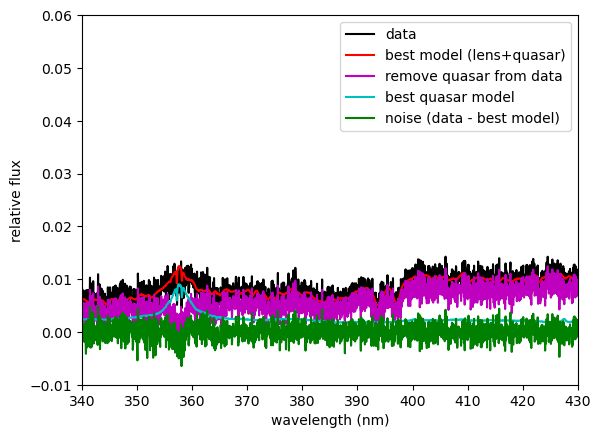

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       187       211
chi2/DOF: 0.01081; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00644   0.00174
Formal errors:
     dV    dsigma   dh3      dh4
      25      27
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         7        53
chi2/DOF: 0.006580; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 18; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00072  7.78e-05
Formal errors:
     dV    dsigma   dh3      dh4
      54      69
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:

 Best Fit:       Vel     sigma
 comp.  0:      1888       878
chi2/DOF: 0.1183; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 20; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0059     0.199
Formal errors:
     dV    dsigma   dh3      dh4
   4e+02 4.5e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:      1888       878
chi2/DOF: 0.1183; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 20; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0059     0.199
Formal errors:
     dV    dsigma   dh3      dh4
   4e+02 

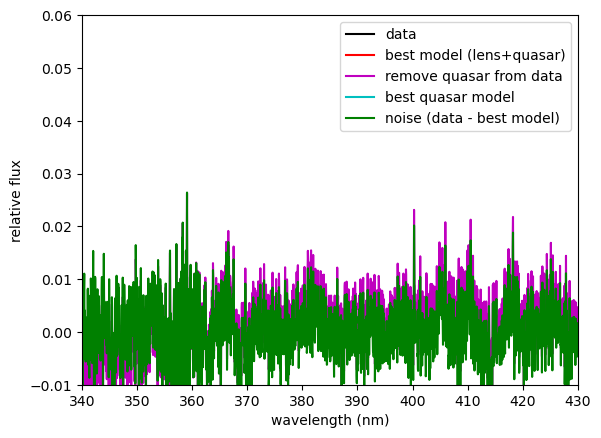

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:      -122       299
chi2/DOF: 0.1225; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000275     0.203
Formal errors:
     dV    dsigma   dh3      dh4
 1.3e+03 3.8e+03
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:   

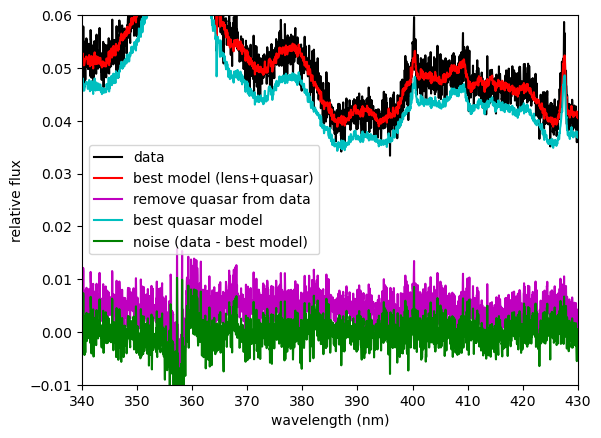

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       189       218
chi2/DOF: 0.01267; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0038    0.0229
Formal errors:
     dV    dsigma   dh3      dh4
      47      51
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

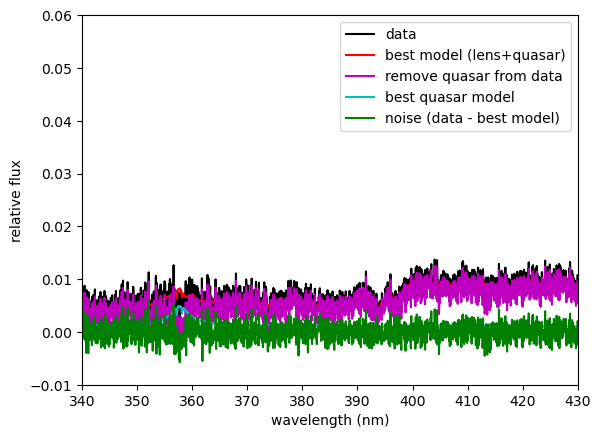

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       190       284
chi2/DOF: 0.01090; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00418    0.0012
Formal errors:
     dV    dsigma   dh3      dh4
      50      54
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         6        93
chi2/DOF: 0.02864; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00108    0.0536
Formal errors:
     dV    dsigma   dh3      dh4
 1.5e+02 1.7e+02
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:      -128       110
chi2/DOF: 0.02973; DOF: 1882; degree =

[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       182       248
chi2/DOF: 0.01501; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00553    0.0154
Formal errors:
     dV    dsigma   dh3      dh4
      39      42
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       187       275
chi2/DOF: 0.009052; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; S

 Best Fit:       Vel     sigma
 comp.  0:       180       314
chi2/DOF: 0.008240; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00318   0.00172
Formal errors:
     dV    dsigma   dh3      dh4
      62      67
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       156       316
chi2/DOF: 0.01087; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0026   0.00167
Formal errors:
     dV    dsigma   dh3      dh4
      

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       252       223
chi2/DOF: 0.02161; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 20; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00109    0.0487
Formal errors:
     dV    dsigma   dh3      dh4
 2.2e+02 2.4e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       283       216
chi2/DOF: 0.03336; DOF: 1882; degree =

 Best Fit:       Vel     sigma
 comp.  0:       172       184
chi2/DOF: 0.02279; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00427    0.0376
Formal errors:
     dV    dsigma   dh3      dh4
      50      55
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       172       184
chi2/DOF: 0.02279; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00427    0.0376
Formal errors:
     dV    dsigma   dh3      dh4
      5

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       117       293
chi2/DOF: 0.01072; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00603   0.00266
Formal errors:
     dV    dsigma   dh3      dh4
      36      38
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:      2000      1000
chi2/DOF: 0.01029; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 9; Func calls: 29; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000567   0.00782
Formal errors:
     dV    dsigma   dh3      dh4
 1.3e+03 1.7e+03
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

 Best Fit:       Vel     sigma
 comp.  0:       327       110
chi2/DOF: 0.04827; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00354    0.0979
Formal errors:
     dV    dsigma   dh3      dh4
      61      72
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       321       113
chi2/DOF: 0.04259; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 20; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00365    0.0927
Formal errors:
     dV    dsigma   dh3      dh4
      5

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       178       304
chi2/DOF: 0.01087; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0122   0.00269
Formal errors:
     dV    dsigma   dh3      dh4
      19      20
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

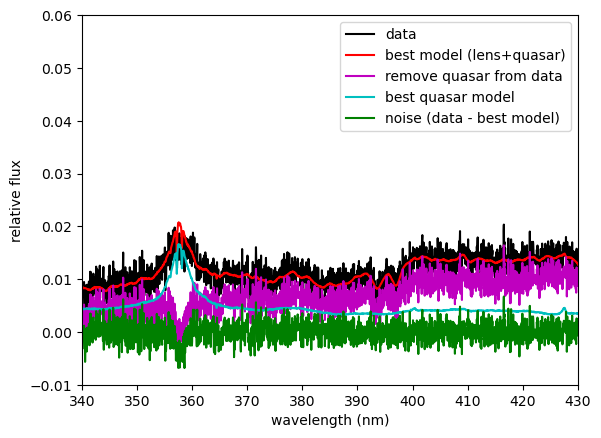

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       119       345
chi2/DOF: 0.01098; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00705   0.00397
Formal errors:
     dV    dsigma   dh3      dh4
      37      40
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.009653; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0     0.008
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       580         0
chi2/DOF: 0.01309; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 9; Func calls: 31; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000867    0.0187
Formal errors:
     dV    dsigma   dh3      dh4
      3

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       239        26
chi2/DOF: 0.04348; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 20; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00287    0.0864
Formal errors:
     dV    dsigma   dh3      dh4
      26      41
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       235        39
chi2/DOF: 0.03858; DOF: 1882; degree =

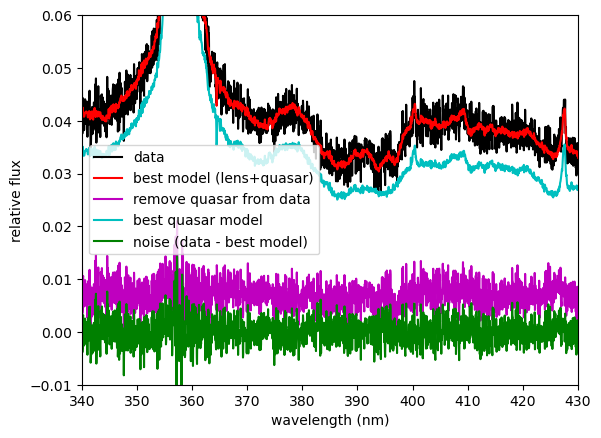

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       106       248
chi2/DOF: 0.01989; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00545    0.0309
Formal errors:
     dV    dsigma   dh3      dh4
      44      47
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:  

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       200       224
chi2/DOF: 0.008743; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00508   0.00708
Formal errors:
     dV    dsigma   dh3      dh4
      30      32
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:

 Best Fit:       Vel     sigma
 comp.  0:       201       233
chi2/DOF: 0.01319; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000558    0.0179
Formal errors:
     dV    dsigma   dh3      dh4
 3.6e+02 3.9e+02
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:      1522      1000
chi2/DOF: 0.01617; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 20; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00317    0.0376
Formal errors:
     dV    dsigma   dh3      dh4
 3.1e+02

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       176       278
chi2/DOF: 0.01323; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0209   0.00534
Formal errors:
     dV    dsigma   dh3      dh4
      11      12
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

 Best Fit:       Vel     sigma
 comp.  0:       129       399
chi2/DOF: 0.01024; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 21; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00211    0.0042
Formal errors:
     dV    dsigma   dh3      dh4
 1.4e+02 1.5e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       470         0
chi2/DOF: 0.009964; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 10; Func calls: 32; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000967   0.00145
Formal errors:
     dV    dsigma   dh3      dh4
     

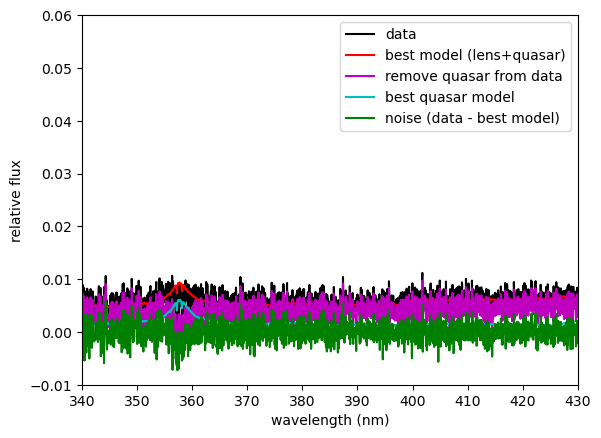

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       286       268
chi2/DOF: 0.006772; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 20; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000861  0.000538
Formal errors:
     dV    dsigma   dh3      dh4
 2.1e+02 2.2e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       436         0
chi2/DOF: 0.07859; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 20; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00224     0.135
Formal errors:
     dV    dsigma   dh3      dh4
      34 2.1e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       193       277
chi2/DOF: 0.01113; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
     0.023   0.00484
Formal errors:
     dV    dsigma   dh3      dh4
     9.2     9.8
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       188       287
chi2/DOF: 0.01379; DOF: 1882; degree =

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       120       497
chi2/DOF: 0.01002; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00216   0.00516
Formal errors:
     dV    dsigma   dh3      dh4
 1.5e+02 1.6e+02
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       212       137
chi2/DOF: 0.01071; DOF: 1882; degree =

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:        78        47
chi2/DOF: 0.04321; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 23; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00124    0.0787
Formal errors:
     dV    dsigma   dh3      dh4
      76   1e+02
Elapsed time in pPXF: 0.06 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       173       289
chi2/DOF: 0.009483; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0256   0.00384
Formal errors:
     dV    dsigma   dh3      dh4
     7.9     8.5
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       173       293
chi2/DOF: 0.01254; DOF: 1882; degree = 3; mdegree = 0
metho

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:        -9       114
chi2/DOF: 0.009521; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00182   0.00187
Formal errors:
     dV    dsigma   dh3      dh4
      45      54
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       318       195
chi2/DOF: 0.03227; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 26; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0031    0.0579
Formal errors:
     dV    dsigma   dh3      dh4
      83      90
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

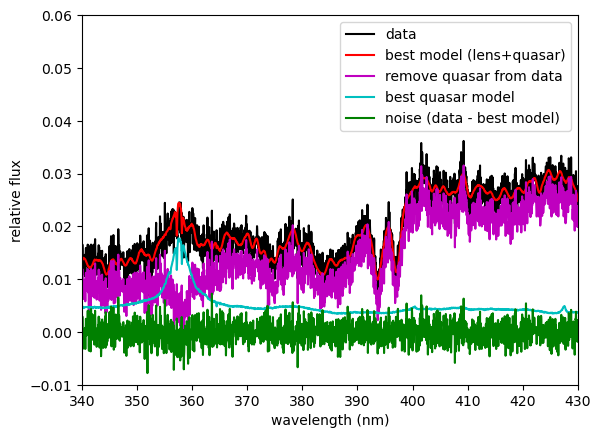

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       183       299
chi2/DOF: 0.008306; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0203   0.00619
Formal errors:
     dV    dsigma   dh3      dh4
     9.7      10
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:

Formal errors:
     dV    dsigma   dh3      dh4
 1.9e+02   2e+02
Elapsed time in pPXF: 0.05 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       218         0
chi2/DOF: 0.009859; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000708   0.00638
Formal errors:
     dV    dsigma   dh3      dh4
      37 2.5e+03
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0

velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       249        35
chi2/DOF: 0.03558; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 23; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0019    0.0616
Formal errors:
     dV    dsigma   dh3      dh4
      42      57
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       250        47
chi2/DOF: 0.03148; DOF: 1882; degree = 3; mdegree = 0
method

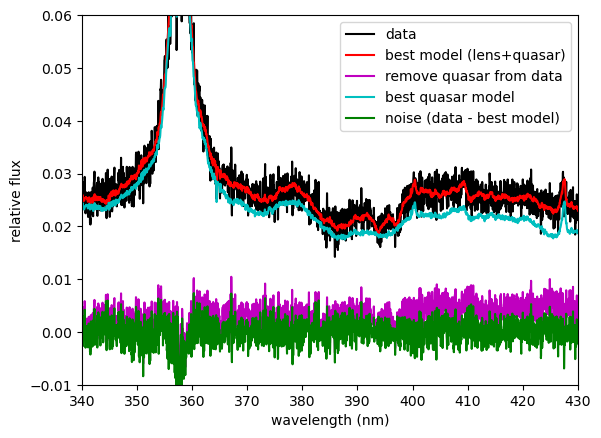

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       228       196
chi2/DOF: 0.01714; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00501    0.0215
Formal errors:
     dV    dsigma   dh3      dh4
      38      41
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

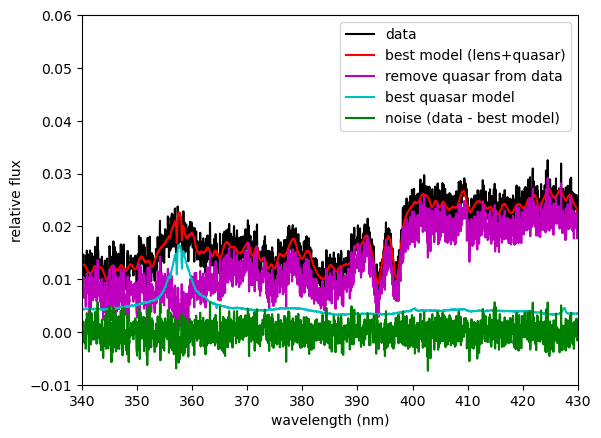

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       194       294
chi2/DOF: 0.007745; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0175   0.00614
Formal errors:
     dV    dsigma   dh3      dh4
      11      11
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:

 Best Fit:       Vel     sigma
 comp.  0:       199       699
chi2/DOF: 0.007046; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000944  0.000868
Formal errors:
     dV    dsigma   dh3      dh4
 3.8e+02 3.8e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       -48       485
chi2/DOF: 0.009232; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 13; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000839  0.000603
Formal errors:
     dV    dsigma   dh3      dh4
 3.5e

 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.1210; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0     0.161
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.1210; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0     0.161
Formal errors:
     dV    dsigma   dh3      dh4
       0   

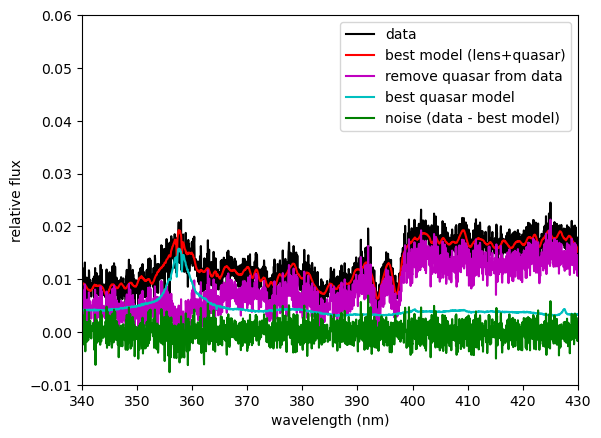

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       172       261
chi2/DOF: 0.01014; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0151   0.00368
Formal errors:
     dV    dsigma   dh3      dh4
      13      13
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

 Best Fit:       Vel     sigma
 comp.  0:        60       570
chi2/DOF: 0.009531; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00177   0.00531
Formal errors:
     dV    dsigma   dh3      dh4
   2e+02 2.1e+02
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       -28       848
chi2/DOF: 0.01050; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 16; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00114   0.00169
Formal errors:
     dV    dsigma   dh3      dh4
   6e+0

velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:      -139         8
chi2/DOF: 0.05911; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 23; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000666    0.0998
Formal errors:
     dV    dsigma   dh3      dh4
      98 3.7e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:      -149         0
chi2/DOF: 0.05850; DOF: 1882; degree = 3; mdegree = 0
method

 Best Fit:       Vel     sigma
 comp.  0:       154       230
chi2/DOF: 0.007719; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00926   0.00547
Formal errors:
     dV    dsigma   dh3      dh4
      16      17
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       162       206
chi2/DOF: 0.01216; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0113   0.00344
Formal errors:
     dV    dsigma   dh3      dh4
      

 Best Fit:       Vel     sigma
 comp.  0:        57       183
chi2/DOF: 0.01163; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00156   0.00447
Formal errors:
     dV    dsigma   dh3      dh4
   1e+02 1.1e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:        49       208
chi2/DOF: 0.009810; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00145   0.00413
Formal errors:
     dV    dsigma   dh3      dh4
      

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.02066; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0    0.0344
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:  

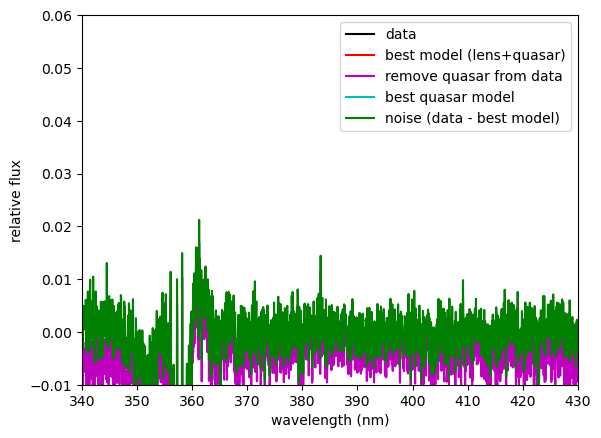

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       256         0
chi2/DOF: 0.03955; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 23; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000548    0.0784
Formal errors:
     dV    dsigma   dh3      dh4
      97 5.8e+03
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

 Best Fit:       Vel     sigma
 comp.  0:       160       256
chi2/DOF: 0.01018; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0108   0.00218
Formal errors:
     dV    dsigma   dh3      dh4
      17      18
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       170       258
chi2/DOF: 0.006553; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00953   0.00302
Formal errors:
     dV    dsigma   dh3      dh4
      

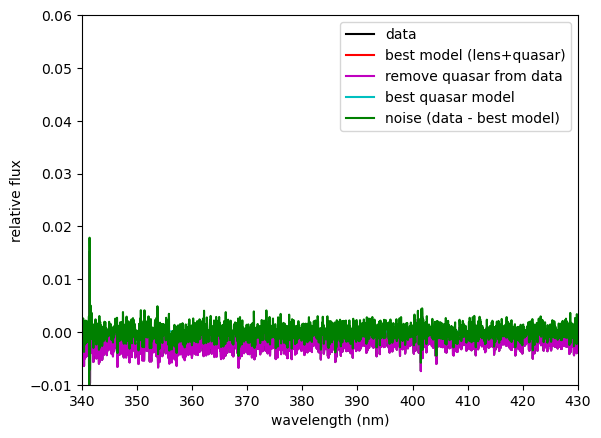

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:      -154       151
chi2/DOF: 0.009385; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 16; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000853   0.00406
Formal errors:
     dV    dsigma   dh3      dh4
 1.1e+02 1.3e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       140       322
chi2/DOF: 0.006726; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00609   0.00358
Formal errors:
     dV    dsigma   dh3      dh4
      32      34
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:

 Best Fit:       Vel     sigma
 comp.  0:        94       415
chi2/DOF: 0.006897; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00251   0.00342
Formal errors:
     dV    dsigma   dh3      dh4
      95   1e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:        84       255
chi2/DOF: 0.009910; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00193   0.00218
Formal errors:
     dV    dsigma   dh3      dh4
      

 Best Fit:       Vel     sigma
 comp.  0:       600       411
chi2/DOF: 0.009890; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 20; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00113    0.0162
Formal errors:
     dV    dsigma   dh3      dh4
 2.6e+02 2.8e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       280       158
chi2/DOF: 0.01406; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 8; Func calls: 27; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00107    0.0192
Formal errors:
     dV    dsigma   dh3      dh4
 1.5e+

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       125       260
chi2/DOF: 0.01038; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00617   0.00158
Formal errors:
     dV    dsigma   dh3      dh4
      30      32
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       164       320
chi2/DOF: 0.007256; DOF: 1882; degree =

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:      -164        56
chi2/DOF: 0.007425; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 8; Func calls: 33; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000688  3.72e-05
Formal errors:
     dV    dsigma   dh3      dh4
      73      87
Elapsed time in pPXF: 0.03 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:

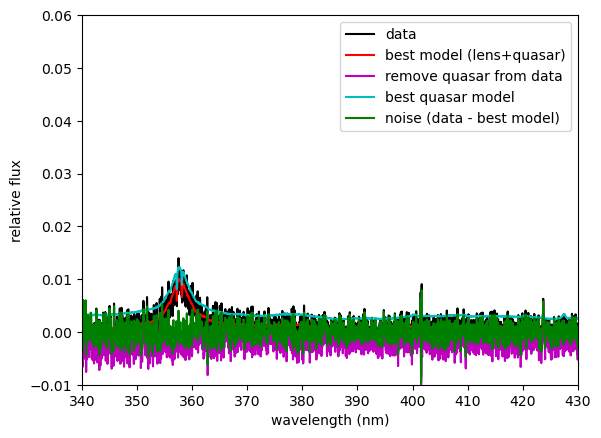

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       535         0
chi2/DOF: 0.01079; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 9; Func calls: 36; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000474   0.00618
Formal errors:
     dV    dsigma   dh3      dh4
      59 3.1e+03
Elapsed time in pPXF: 0.03 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

 Best Fit:       Vel     sigma
 comp.  0:       -21        60
chi2/DOF: 0.01287; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00121   0.00795
Formal errors:
     dV    dsigma   dh3      dh4
      48      60
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:        77        87
chi2/DOF: 0.007777; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 23; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00203   0.00472
Formal errors:
     dV    dsigma   dh3      dh4
      

velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       103       192
chi2/DOF: 0.008942; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0023    0.0011
Formal errors:
     dV    dsigma   dh3      dh4
      58      63
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       142        15
chi2/DOF: 0.006715; DOF: 1882; degree = 3; mdegree = 0
meth

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:      -153       259
chi2/DOF: 0.008988; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 13; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000733   0.00221
Formal errors:
     dV    dsigma   dh3      dh4
 2.7e+02 2.9e+02
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       215       234
chi2/DOF: 0.01066; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00219   0.00307
Formal errors:
     dV    dsigma   dh3      dh4
      78      83
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       307       127
chi2/DOF: 0.005793; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 8; Func calls: 28; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000952  0.000673
Formal errors:
     dV    dsigma   dh3      dh4
      84      97
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       181       278
chi2/DOF: 0.009084; DOF: 1882; degree

 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.01048; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0    0.0107
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:      -722         9
chi2/DOF: 0.01470; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 11; Func calls: 38; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000858     0.013
Formal errors:
     dV    dsigma   dh3      dh4
      3

velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       129       200
chi2/DOF: 0.01022; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00203  0.000713
Formal errors:
     dV    dsigma   dh3      dh4
      79      85
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       123       202
chi2/DOF: 0.008957; DOF: 1882; degree = 3; mdegree = 0
metho

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.006597; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0  0.000149
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008879; DOF: 1884; degree 

 Best Fit:       Vel     sigma
 comp.  0:      -214       101
chi2/DOF: 0.01199; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 22; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000789   0.00585
Formal errors:
     dV    dsigma   dh3      dh4
 1.1e+02 1.3e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:      -203        97
chi2/DOF: 0.01080; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 22; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000772   0.00564
Formal errors:
     dV    dsigma   dh3      dh4
   1e+0

 Best Fit:       Vel     sigma
 comp.  0:       247         0
chi2/DOF: 0.009080; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 14; Func calls: 46; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00142  9.67e-05
Formal errors:
     dV    dsigma   dh3      dh4
      18 1.3e+03
Elapsed time in pPXF: 0.03 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       250         0
chi2/DOF: 0.007850; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 12; Func calls: 40; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00143  0.000115
Formal errors:
     dV    dsigma   dh3      dh4
   

 Best Fit:       Vel     sigma
 comp.  0:      -149       210
chi2/DOF: 0.009584; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000585   0.00146
Formal errors:
     dV    dsigma   dh3      dh4
 2.6e+02 2.8e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:      -149       210
chi2/DOF: 0.009584; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000585   0.00146
Formal errors:
     dV    dsigma   dh3      dh4
 2.6e

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:      -242       443
chi2/DOF: 0.008921; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00112   0.00159
Formal errors:
     dV    dsigma   dh3      dh4
 2.1e+02 2.3e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       -17       283
chi2/DOF: 0.01189; DOF: 1882; degree 

velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:      -282         0
chi2/DOF: 0.007379; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 23; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
  0.000563         0
Formal errors:
     dV    dsigma   dh3      dh4
      40 2.7e+03
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:      -163        58
chi2/DOF: 0.008756; DOF: 1882; degree = 3; mdegree = 0
meth

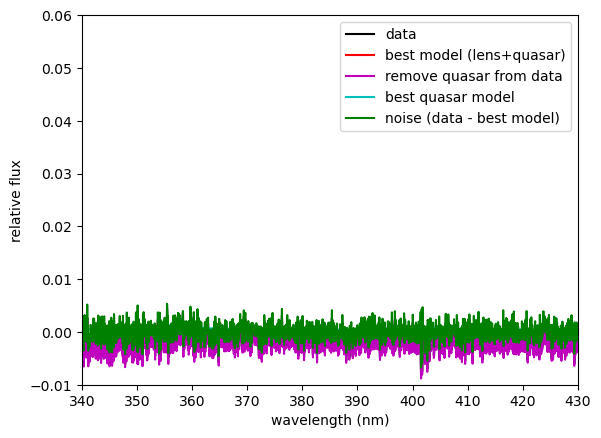

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:      -357        99
chi2/DOF: 0.008763; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 26; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00062  0.000668
Formal errors:
     dV    dsigma   dh3      dh4
 1.2e+02 1.5e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:

 Best Fit:       Vel     sigma
 comp.  0:      -399       506
chi2/DOF: 0.007544; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000298   0.00135
Formal errors:
     dV    dsigma   dh3      dh4
 1.1e+03 1.1e+03
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       250       394
chi2/DOF: 0.01022; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000276   0.00125
Formal errors:
     dV    dsigma   dh3      dh4
 1.2e+

 Best Fit:       Vel     sigma
 comp.  0:       327         0
chi2/DOF: 0.008536; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 8; Func calls: 32; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
  0.000543         0
Formal errors:
     dV    dsigma   dh3      dh4
      46 3.1e+03
Elapsed time in pPXF: 0.03 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       361         0
chi2/DOF: 0.005524; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
  0.000443         0
Formal errors:
     dV    dsigma   dh3      dh4
     

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.006836; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00126
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.009531; DOF: 1884; degree 

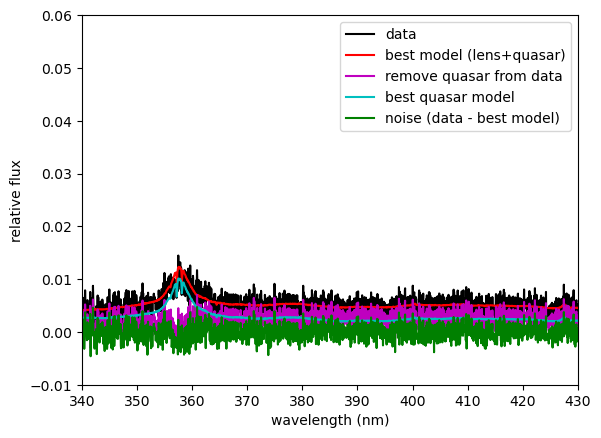

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:      -394       153
chi2/DOF: 0.01034; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 20; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000569   0.00196
Formal errors:
     dV    dsigma   dh3      dh4
 1.8e+02 2.2e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

 Best Fit:       Vel     sigma
 comp.  0:       266         0
chi2/DOF: 0.006108; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 23; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
   0.00088         0
Formal errors:
     dV    dsigma   dh3      dh4
      24 1.1e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       270         0
chi2/DOF: 0.008880; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 9; Func calls: 35; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000512  2.74e-05
Formal errors:
     dV    dsigma   dh3      dh4
     

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:      2000      1000
chi2/DOF: 0.005418; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
  0.000574         0
Formal errors:
     dV    dsigma   dh3      dh4
 9.7e+02 1.2e+03
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:      -128       536
chi2/DOF: 0.008086; DOF: 1882; degree

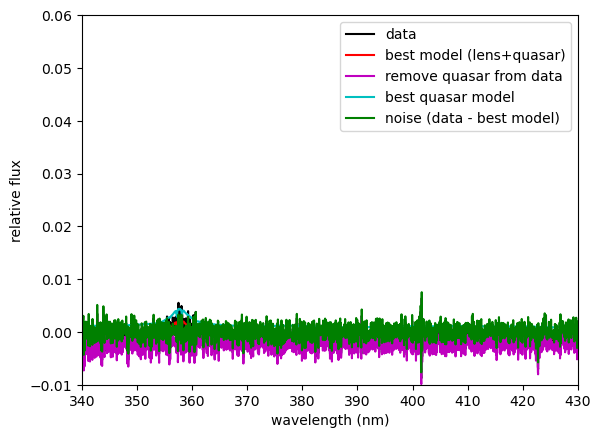

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.009210; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00106
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

 Best Fit:       Vel     sigma
 comp.  0:       -28         0
chi2/DOF: 0.01106; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00063  0.000233
Formal errors:
     dV    dsigma   dh3      dh4
      45 3.2e+03
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:      -191       273
chi2/DOF: 0.007277; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000566  0.000321
Formal errors:
     dV    dsigma   dh3      dh4
 2.6e+0

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008386; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0  0.000268
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.009009; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0  0.000225
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

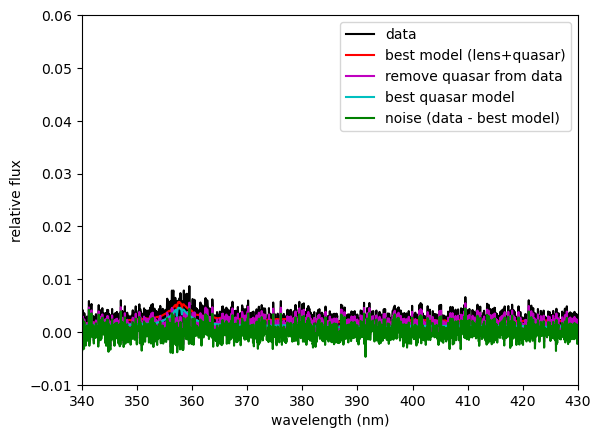

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.01039; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00132
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:  

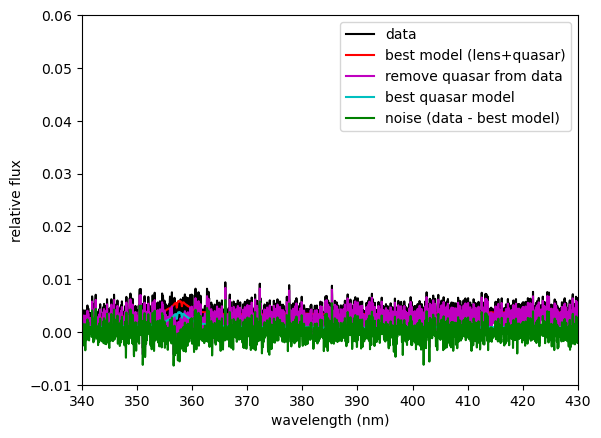

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.009476; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0  0.000889
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

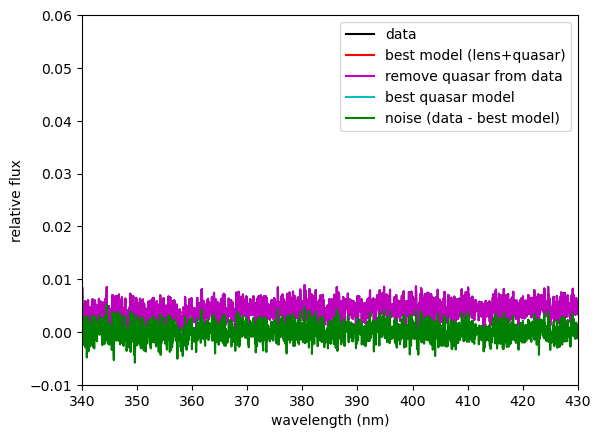

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:      -579       233
chi2/DOF: 0.01018; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
  0.000672         0
Formal errors:
     dV    dsigma   dh3      dh4
 2.4e+02 2.6e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

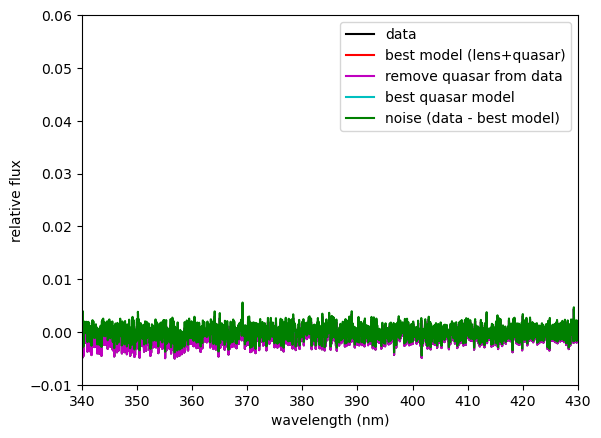

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008410; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0         0
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       144         0
chi2/DOF: 0.006306; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 28; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000562  0.000152
Formal errors:
     dV    dsigma   dh3      dh4
      38 2.6e+02
Elapsed time in pPXF: 0.03 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       208         0
chi2/DOF: 0.009619; DOF: 1882; degree

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008978; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0  1.96e-05
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.006027; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
  9.22e-05         0
Formal errors:
     dV    dsigma   dh3      dh4
 1.5e+03 9.9e+02
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       -78        37
chi2/DOF: 0.008554; DOF: 1882; degree 

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:        15         0
chi2/DOF: 0.006566; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 20; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000433  0.000368
Formal errors:
     dV    dsigma   dh3      dh4
      50 2.9e+03
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:

 Best Fit:       Vel     sigma
 comp.  0:       200         0
chi2/DOF: 0.009695; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 8; Func calls: 35; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
  0.000275         0
Formal errors:
     dV    dsigma   dh3      dh4
      96 2.9e+03
Elapsed time in pPXF: 0.03 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       213         0
chi2/DOF: 0.006567; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 25; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
  0.000146         0
Formal errors:
     dV    dsigma   dh3      dh4
 1.4e

velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       197         0
chi2/DOF: 0.005447; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 22; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
    0.0003         0
Formal errors:
     dV    dsigma   dh3      dh4
      66 3.7e+03
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:       199         7
chi2/DOF: 0.008189; DOF: 1882; degree = 3; mdegree = 0
meth

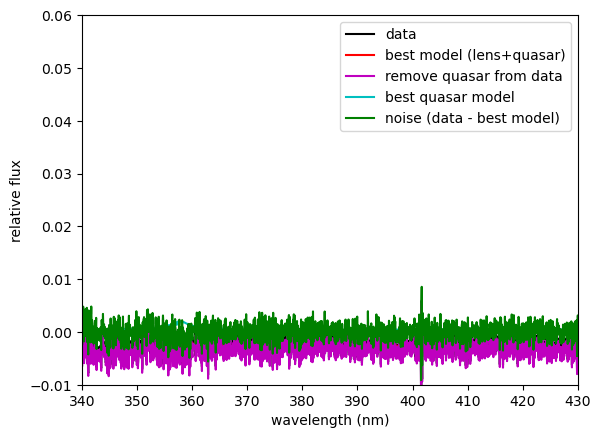

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008832; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0  0.000496
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.009131; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0  0.000532
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008137; DOF: 1884; degree 

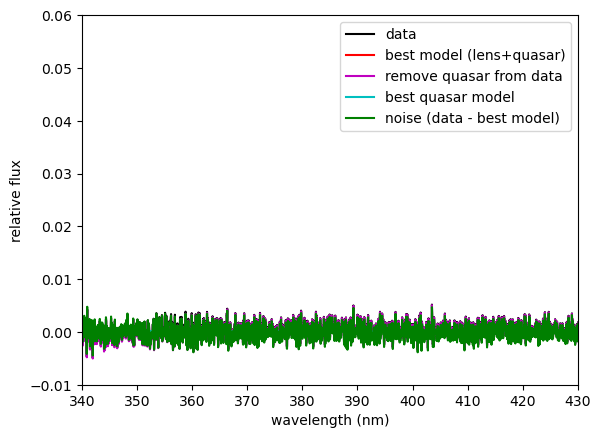

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:      -248         0
chi2/DOF: 0.009008; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 25; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000335  0.000116
Formal errors:
     dV    dsigma   dh3      dh4
      75 4.3e+03
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008686; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0  0.000272
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
noise 2 [0.014 0.014 0.014 ... 0.014 0.014 0.014]
 Best Fit: 

<Figure size 640x480 with 0 Axes>

In [26]:
data_no_quasar = np.empty_like(data_crop[0].data)
noise_cube = np.empty_like(data_crop[0].data)

for i in range(radius_in_pixels*2+1):
    for j in range(radius_in_pixels*2+1):
        #print (i, j)
        spectrum_perpixel = data_crop[0].data[:,i,j]
        data_no_quasar[:,i,j], noise_cube[:,i,j], sky = remove_quasar_from_galaxy_deredshift(libary_dir, 
                     degree=degree, spectrum_aperture=spectrum_aperture, wave_min=wave_min,
                     wave_max=wave_max, velscale_ratio=velscale_ratio, quasar_spectrum=quasar_spectrum_A,
                     z=z, noise=noise, templates_name='xshooter', FWHM=FWHM_gal,
                     FWHM_tem=FWHM_tem_xshooter, global_temp=global_temp1, plot=False,
                     spectrum_perpixel=spectrum_perpixel, random_plot=True)

In [27]:
## store the data if necessary
hdu_noquasar = hdu.copy()
hdu_noquasar[0].data = data_no_quasar
hdu_noquasar.writeto(dir+name+'_noquasar.fits', overwrite=True)

hdu_noise = hdu.copy()
hdu_noise[0].data = noise_cube
hdu_noise.writeto(dir+name+'_noise.fits', overwrite=True)

### Load the quasar contribution removed data and get a SNR map using restframe wavelength range 3985 - 4085 Ang. In the observed wavelength that is 5160 - 5290 Ang. This region is after Ca H&K and before H-delta lines.

In [28]:
hdu_noquasar = fits.open(dir+name+'_noquasar.fits')
hdu_noise = fits.open(dir+name+'_noise.fits')

data_no_quasar = hdu_noquasar[0].data
noise_cube = hdu_noise[0].data

lin_axis_sky = np.linspace(lamRange1[0], lamRange1[1], data_no_quasar.shape[0])
ind_min = find_nearest(lin_axis_sky, 3985)
ind_max = find_nearest(lin_axis_sky, 4085)
ind_min, ind_max

(3663, 3922)

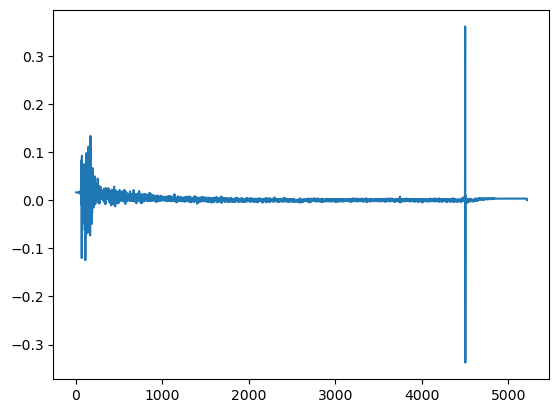

In [29]:
plt.plot(noise_cube[:, 0, 0])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


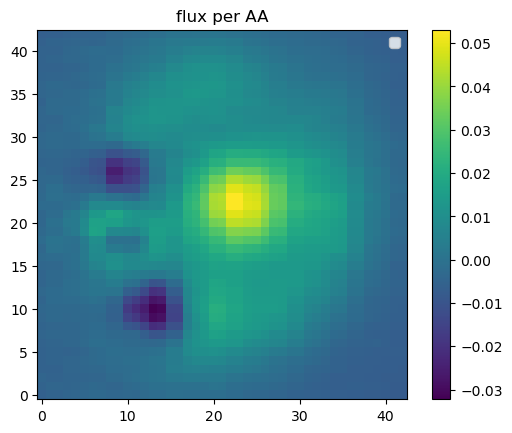

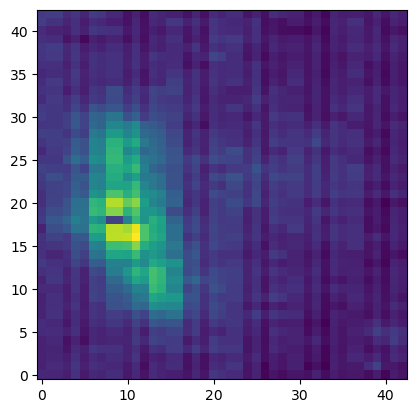

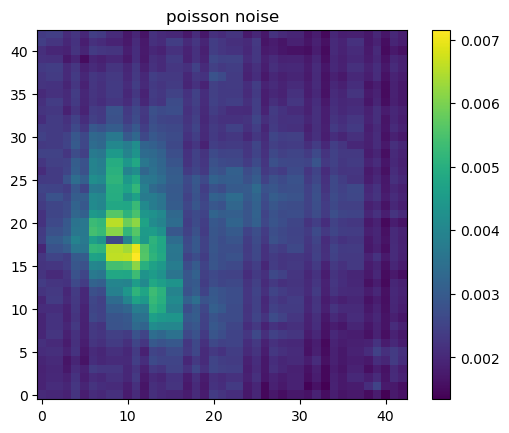

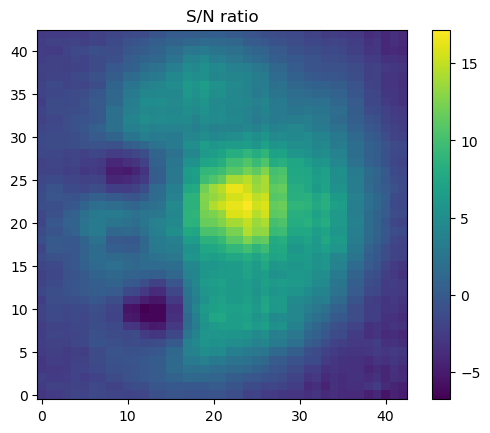

In [30]:
SN_per_AA, flux_per_AA, sigma_poisson = SN_CaHK(ind_min, ind_max, data_no_quasar, noise_cube, T_exp)

### Select a region using the SNR map and a chosen radius and apply voronoi binning to the pixels within that region

In [31]:
def mask_within_radius(arr, x, y, r):
    """
    """
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            d = np.sqrt((x - i)**2 + (y - j)**2)
            if d < r:
                arr[j, i] = 0.
                
    return arr

22 23


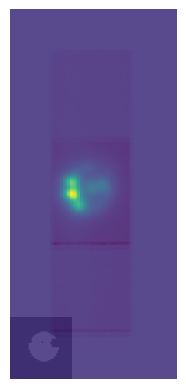

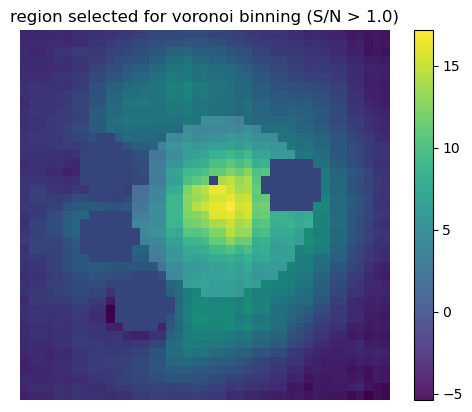

In [32]:
# SN_y_center, SN_x_center = np.unravel_index(SN_per_AA.argmax(), SN_per_AA.shape)
SN_y_center, SN_x_center = int(gal_y), int(gal_x)

SN_per_AA[int(sat_y), int(sat_x)] = 0.

# SN_per_AA[SN_y_center, SN_x_center] = 0.
for a, b in zip(image_x, image_y):
    sigma = 0.98 / 2.355 / 0.1457
    SN_per_AA = mask_within_radius(SN_per_AA, a, b, 1.2 * sigma)


max_radius = 1.5 / 0.1457 # 1.5 arcsec
target_SN = 1.
print(SN_y_center, SN_x_center)

hdu_full = fits.open(dir+name+'.fits')

origin_imaging_data_perAA = np.mean(hdu_full[0].data[ind_min:ind_max,:,:], axis=0)*2

mask = select_region(dir, origin_imaging_data_perAA, SN_per_AA, SN_x_center,
               SN_y_center, radius_in_pixels,
              max_radius, target_SN, name)

minimum S/N within region: 1.404817154497322


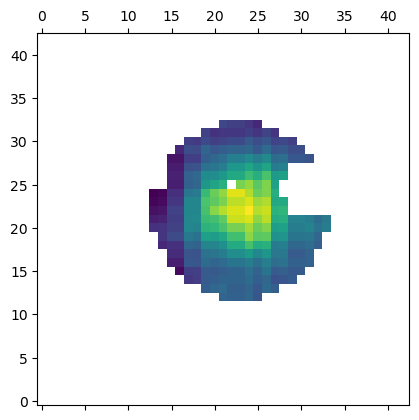

In [33]:
# temp_mask = np.ones_like(SN_per_AA)
#
# temp_mask = mask_within_radius(temp_mask, SN_x_center, SN_y_center, max_radius)
#
# temp_mask2 = 1 - temp_mask
# temp_mask2[25, 14] = 0
a = mask * SN_per_AA
a[a == 0] = np.inf

plt.matshow(a, origin='lower');

# a[25, 14] = 1e10

print('minimum S/N within region:', np.min(a))

#### Convert the pixel coordinates in arcsec unit before binning, then perform binning using pixel coordinates in arcsec unit and after binning bring them back to cartesian coordinates.

In [34]:
x, y, signal, noise = np.loadtxt(dir+'voronoi_2d_binning_'+name+'_input.txt').T

x -= SN_x_center
y -= SN_y_center
x *= 0.1457 # pixel scale of the KCWI data
y *= 0.1457

vor_input = np.vstack((x, y, signal, noise)).T
np.savetxt(dir + 'voronoi_2d_binning_' + name + '_arcsec_input.txt', vor_input,
               fmt=b'%10.6f %10.6f %10.6f %10.6f')

In [35]:
x, y, signal, noise = np.loadtxt(dir+'voronoi_2d_binning_'+name+'_input.txt').T

for a, b in zip(x, y):
    print(a, b)

21.0 12.0
22.0 12.0
23.0 12.0
24.0 12.0
25.0 12.0
19.0 13.0
20.0 13.0
21.0 13.0
22.0 13.0
23.0 13.0
24.0 13.0
25.0 13.0
26.0 13.0
27.0 13.0
17.0 14.0
18.0 14.0
19.0 14.0
20.0 14.0
21.0 14.0
22.0 14.0
23.0 14.0
24.0 14.0
25.0 14.0
26.0 14.0
27.0 14.0
28.0 14.0
29.0 14.0
16.0 15.0
17.0 15.0
18.0 15.0
19.0 15.0
20.0 15.0
21.0 15.0
22.0 15.0
23.0 15.0
24.0 15.0
25.0 15.0
26.0 15.0
27.0 15.0
28.0 15.0
29.0 15.0
30.0 15.0
15.0 16.0
16.0 16.0
17.0 16.0
18.0 16.0
19.0 16.0
20.0 16.0
21.0 16.0
22.0 16.0
23.0 16.0
24.0 16.0
25.0 16.0
26.0 16.0
27.0 16.0
28.0 16.0
29.0 16.0
30.0 16.0
31.0 16.0
15.0 17.0
16.0 17.0
17.0 17.0
18.0 17.0
19.0 17.0
20.0 17.0
21.0 17.0
22.0 17.0
23.0 17.0
24.0 17.0
25.0 17.0
26.0 17.0
27.0 17.0
28.0 17.0
29.0 17.0
30.0 17.0
31.0 17.0
14.0 18.0
15.0 18.0
16.0 18.0
17.0 18.0
18.0 18.0
19.0 18.0
20.0 18.0
21.0 18.0
22.0 18.0
23.0 18.0
24.0 18.0
25.0 18.0
26.0 18.0
27.0 18.0
28.0 18.0
29.0 18.0
30.0 18.0
31.0 18.0
32.0 18.0
14.0 19.0
15.0 19.0
16.0 19.0
17.0 19.0
18.0 19.0


### Bin the pixels using target SNs

In [36]:
snr_1 = 23
snr_2 = 28

Bin-accretion...
1  /  43
2  /  43
3  /  43
4  /  43
5  /  43
6  /  43
7  /  43
8  /  43
9  /  43
10  /  43
11  /  43
12  /  43
13  /  43
14  /  43
15  /  43
16  /  43
17  /  43
18  /  43
19  /  43
20  /  43
21  /  43
22  /  43
23  /  43
24  /  43
25  /  43
26  /  43
27  /  43
28  /  43
29  /  43
30  /  43
31  /  43
32  /  43
33  /  43
34  /  43
35  /  43
36  /  43
37  /  43
38  /  43
39  /  43
40  /  43
41  /  43
42  /  43
43  /  43
44  /  43
45  /  43
46  /  43
47  /  43
48  /  43
49  /  43
50  /  43
51  /  43
52  /  43
52  initial bins.
Reassign bad bins...
41  good bins.
Modified Lloyd algorithm...
Iter:    1  Diff: 1.91
Iter:    2  Diff: 0.914
Iter:    3  Diff: 0.5297
Iter:    4  Diff: 0.152
Iter:    5  Diff: 0.1777
Iter:    6  Diff: 0
5  iterations.
Unbinned pixels:  0  /  302
Fractional S/N scatter (%): 10.291763407171963
Elapsed time accretion: 0.01 seconds
Elapsed time optimization: 0.00 seconds


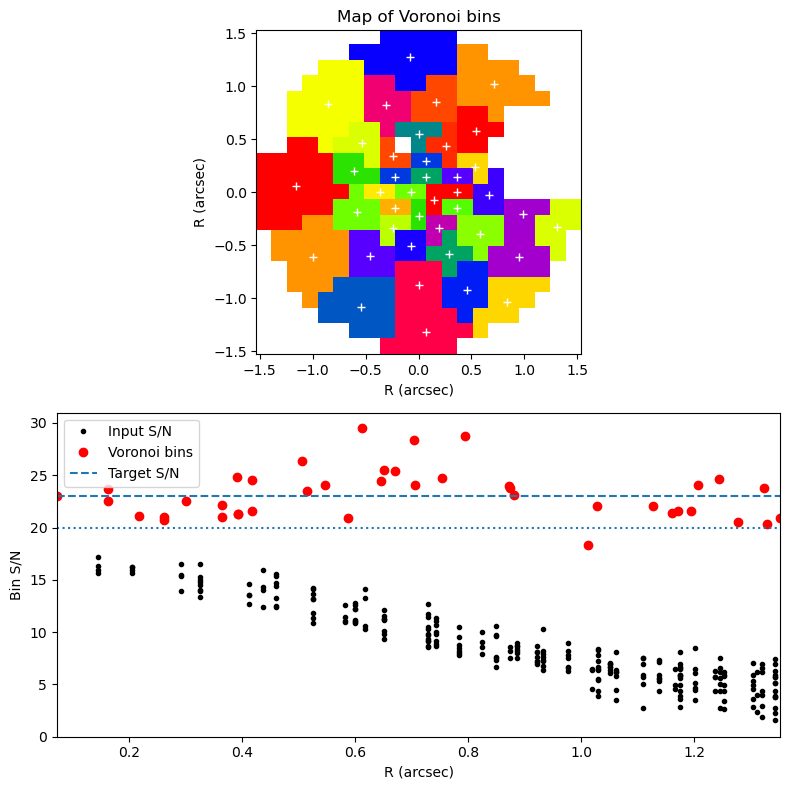

In [37]:
bin_target_SN = snr_1
plt.figure(figsize=(8, 8))
voronoi_binning(bin_target_SN, dir, name+'_arcsec')
plt.axhline(20, ls=':')
plt.tight_layout()
plt.pause(1)

In [38]:
# convert back to cartesian coordiantes
output = np.loadtxt(dir +'voronoi_2d_binning_' + name+ '_arcsec_output.txt')

x, y, binNum = output.T[0], output.T[1], output.T[2]

x = x / 0.1457 + SN_x_center
y = y / 0.1457 + SN_y_center

np.savetxt(dir+'voronoi_2d_binning_'+ name +'_targetSN_{}_output.txt'.format(snr_1), \
                      np.column_stack([x, y, binNum]),fmt=b'%10.6f %10.6f %8i')

Bin-accretion...
1  /  29
2  /  29
3  /  29
4  /  29
5  /  29
6  /  29
7  /  29
8  /  29
9  /  29
10  /  29
11  /  29
12  /  29
13  /  29
14  /  29
15  /  29
16  /  29
17  /  29
18  /  29
19  /  29
20  /  29
21  /  29
22  /  29
23  /  29
24  /  29
25  /  29
26  /  29
27  /  29
28  /  29
29  /  29
30  /  29
31  /  29
32  /  29
33  /  29
34  /  29
35  /  29
35  initial bins.
Reassign bad bins...
27  good bins.
Modified Lloyd algorithm...
Iter:    1  Diff: 2.7
Iter:    2  Diff: 0.6312
Iter:    3  Diff: 0.428
Iter:    4  Diff: 0.3078
Iter:    5  Diff: 0
4  iterations.
Unbinned pixels:  0  /  302
Fractional S/N scatter (%): 12.89217130360661
Elapsed time accretion: 0.02 seconds
Elapsed time optimization: 0.00 seconds


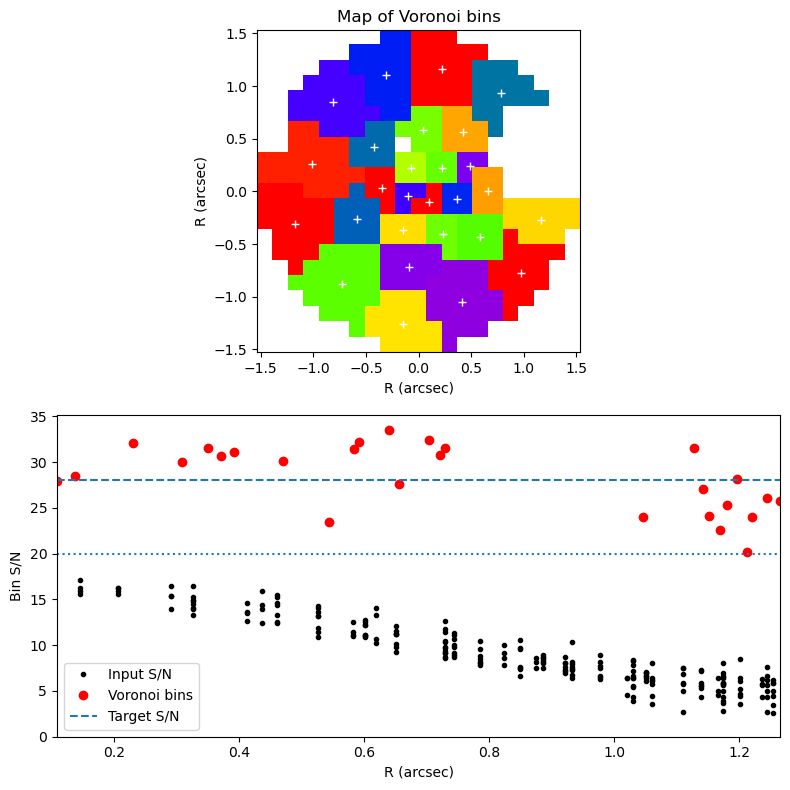

In [39]:
bin_target_SN = snr_2
plt.figure(figsize=(8, 8))
voronoi_binning(bin_target_SN, dir, name+'_arcsec')
plt.axhline(20, ls=':')
plt.tight_layout()
plt.pause(1)

In [40]:
# convert back to cartesian coordiantes
output = np.loadtxt(dir +'voronoi_2d_binning_' + name+ '_arcsec_output.txt')

x, y, binNum = output.T[0], output.T[1], output.T[2]

x = x / 0.1457 + SN_x_center
y = y / 0.1457 + SN_y_center

np.savetxt(dir+'voronoi_2d_binning_'+ name +'_targetSN_{}_output.txt'.format(snr_2), \
                      np.column_stack([x, y, binNum]),fmt=b'%10.6f %10.6f %8i')

### Now bin the data using the voronoi binning map

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

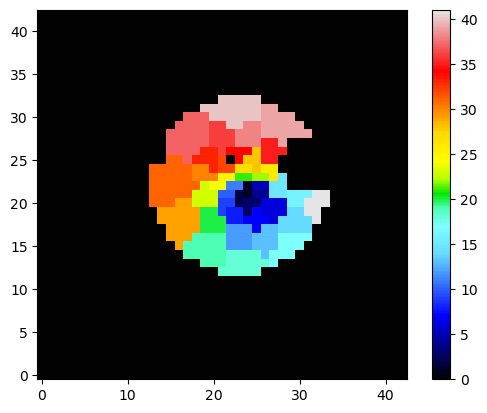

In [41]:
get_voronoi_binning_data(dir, name, name+'_targetSN_{}'.format(snr_1))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

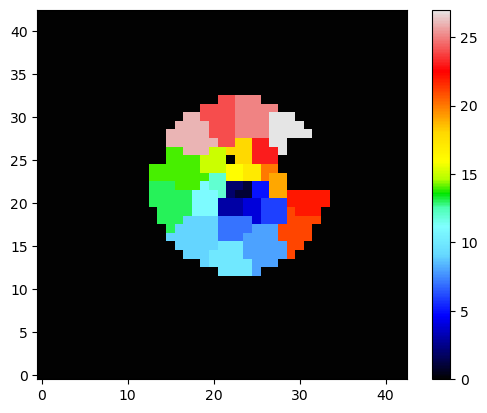

In [42]:
get_voronoi_binning_data(dir, name, name+'_targetSN_{}'.format(snr_2))

### Measure the kinematics

In [43]:
voronoi_binning_data = fits.getdata(dir +'voronoi_binning_' + name + '_targetSN_{}'.format(snr_1) + '_data.fits')

get_velocity_dispersion_deredshift(degree=degree,
                                   spectrum_aperture=spectrum_aperture,
                                   voronoi_binning_data=voronoi_binning_data,
                                   velscale_ratio=velscale_ratio,
                                   z=z, noise=noise, FWHM=FWHM_gal,
                                   FWHM_tem_xshooter=FWHM_tem_xshooter,
                                   dir=dir, libary_dir=libary_dir,
                                   global_temp=global_temp1,
                                   quasar_spectrum=quasar_spectrum_A,
                                   wave_min=wave_min, wave_max=wave_max,
                                   T_exp=T_exp, VD_name='targetSN_{}'.format(snr_1),
                                   plot=False)

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (302,)
noise 1 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

 Best Fit:       Vel     sigma
 comp.  0:       186       284
chi2/DOF: 4.508e-05; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0966    0.0211
Formal errors:
     dV    dsigma   dh3      dh4
      10      11
Elapsed time in pPXF: 0.02 s
[nan] 5.53457637420828e-05
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.0072602  0.00726028 0.00726037 ... 0.0081545  0.00815353 0.00743947]
noise 2 [0.0072602  0.00726028 0.00726037 ... 0.0081545  0.00815353 0.00743947]
 Best Fit:       Vel     sigma
 comp.  0:       187       284
chi2/DOF: 0.7320; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templat

 Best Fit:       Vel     sigma
 comp.  0:       188       287
chi2/DOF: 1.081e-05; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0567   0.00677
Formal errors:
     dV    dsigma   dh3      dh4
     8.6     9.2
Elapsed time in pPXF: 0.02 s
[nan] 1.4142754618513789e-05
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.0034238  0.00342411 0.00342442 ... 0.00452885 0.00452786 0.00376069]
noise 2 [0.0034238  0.00342411 0.00342442 ... 0.00452885 0.00452786 0.00376069]
 Best Fit:       Vel     sigma
 comp.  0:       189       288
chi2/DOF: 0.6338; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templ

 Best Fit:       Vel     sigma
 comp.  0:       176       261
chi2/DOF: 3.026e-05; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0749    0.0342
Formal errors:
     dV    dsigma   dh3      dh4
     9.9      11
Elapsed time in pPXF: 0.01 s
[nan] 3.600519964831639e-05
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.00646769 0.00646707 0.00646647 ... 0.00668312 0.00668212 0.00600043]
noise 2 [0.00646769 0.00646707 0.00646647 ... 0.00668312 0.00668212 0.00600043]
 Best Fit:       Vel     sigma
 comp.  0:       176       261
chi2/DOF: 0.7161; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templa

 Best Fit:       Vel     sigma
 comp.  0:       187       273
chi2/DOF: 0.7397; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0894     0.063
Formal errors:
     dV    dsigma   dh3      dh4
      12      13
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (302,)
noise 1 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (302,)
noise 1 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.00460157 0.00460167 0.00460178 ... 0.00568611 0.00568493 0.00482993]
noise 2 [0.00460157 0.00460167 0.00460178 ... 0.00568611 0.00568493 0.00482993]
 Best Fit:       Vel     sigma
 comp.  0:       191       294
chi2/DOF: 0.6838; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0831    0.0157
Formal errors:
     dV    dsigma   dh3      dh4
     8.1     8.7
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (302,)
noise 1 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

[nan] 2.8096513665513512e-05
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.00524437 0.00524425 0.00524413 ... 0.00599141 0.00599025 0.00530061]
noise 2 [0.00524437 0.00524425 0.00524413 ... 0.00599141 0.00599025 0.00530061]
 Best Fit:       Vel     sigma
 comp.  0:       178       266
chi2/DOF: 0.7106; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0781     0.012
Formal errors:
     dV    dsigma   dh3      dh4
     8.4       9
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (302,)
noise 1 [1. 1. 1. 1. 1. 

velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (302,)
noise 1 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.

<Figure size 640x480 with 0 Axes>

In [44]:
measurements = np.loadtxt(dir + 'VD_%s.txt' % 'targetSN_{}'.format(snr_1))
measurements.shape

(41, 4)

### The bins with a velocity dispersion value > 350 or < 150 have been excluded and filled with 'NaN'. The number of those bins are printed below.¶

In [45]:
for i in range(measurements.shape[0]):
    if measurements[i][1] > 350 or measurements[i][1] < 150:
        print(i) # excluded bins
        measurements[i][0], measurements[i][1] = np.nan, np.nan
        measurements[i][2], measurements[i][3] = np.nan, np.nan
        
np.savetxt(dir + 'VD_%s_excluding_bins.txt' % 'targetSN_{}'.format(snr_1), measurements, fmt='%1.4e')

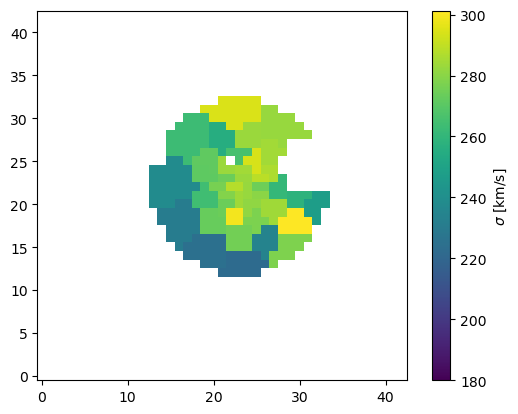

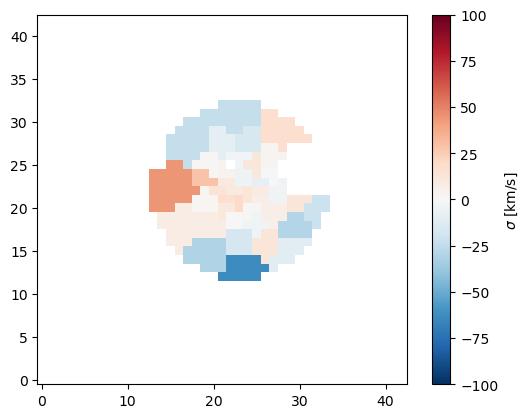

In [46]:
## kinematics map after excluding few bins and filling them with nan
VD_2d, dVD_2d, V_2d, dV_2d = kinematics_map(dir, name +'_targetSN_{}'.format(snr_1), radius_in_pixels=21,
                                            VD_name='targetSN_{}_excluding_bins'.format(snr_1), vd_val=1000)

plt.imshow(VD_2d, origin='lower', cmap='viridis', vmin=180)
cbar = plt.colorbar()
cbar.set_label(r'$\sigma$ [km/s]')
plt.show()

plt.imshow(V_2d - 180, origin='lower', cmap='RdBu_r', vmax=100, vmin=-100) #, vmin=180)
cbar = plt.colorbar()
cbar.set_label(r'$\sigma$ [km/s]')
plt.show()

In [47]:

## kinematics for bins with target SN 26
voronoi_binning_data = fits.getdata(dir +'voronoi_binning_' + name + '_targetSN_{}'.format(snr_2) + '_data.fits')

get_velocity_dispersion_deredshift(degree=degree,
                                   spectrum_aperture=spectrum_aperture,
                                   voronoi_binning_data=voronoi_binning_data,
                                   velscale_ratio=velscale_ratio,
                                   z=z, noise=noise, FWHM=FWHM_gal,
                                   FWHM_tem_xshooter=FWHM_tem_xshooter,
                                   dir=dir, libary_dir=libary_dir,
                                   global_temp=global_temp1,
                                   quasar_spectrum=quasar_spectrum_A,
                                   wave_min=wave_min, wave_max=wave_max,
                                   T_exp=T_exp, VD_name='targetSN_{}'.format(snr_2),
                                   plot=False)

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (302,)
noise 1 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (302,)
noise 1 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (5215,)
noise 1 [0.0123491  0.01234907 0.01234905 ... 0.01268216 0.01268178 0.01227157]
noise 2 [0.0123491  0.01234907 0.01234905 ... 0.01268216 0.01268178 0.01227157]
 Best Fit:       Vel     sigma
 comp.  0:       130       206
chi2/DOF: 0.8419; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0623    0.0868
Formal errors:
     dV    dsigma   dh3      dh4
      20      22
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (302,)
noise 1 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

 Best Fit:       Vel     sigma
 comp.  0:       174       277
chi2/DOF: 0.7180; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
      0.11    0.0126
Formal errors:
     dV    dsigma   dh3      dh4
       7     7.5
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (302,)
noise 1 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

Formal errors:
     dV    dsigma   dh3      dh4
      20      21
Elapsed time in pPXF: 0.05 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (302,)
noise 1 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

 Best Fit:       Vel     sigma
 comp.  0:       158       263
chi2/DOF: 0.7680; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
     0.126     0.175
Formal errors:
     dV    dsigma   dh3      dh4
      14      15
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
shapes (5215,) (302,)
noise 1 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

<Figure size 640x480 with 0 Axes>

In [48]:
measurements = np.loadtxt(dir + 'VD_%s.txt' % 'targetSN_{}'.format(snr_2))
measurements.shape

(27, 4)

### The bins with a velocity dispersion value > 350 or < 150 have been excluded and filled with 'NaN'. The number of those bins are printed below.

In [49]:
for i in range(measurements.shape[0]):
    if measurements[i][1] > 350 or measurements[i][1] < 150:
        print(i) # excluded bins
        measurements[i][0], measurements[i][1] = np.nan, np.nan
        measurements[i][2], measurements[i][3] = np.nan, np.nan
        
np.savetxt(dir + 'VD_%s_excluding_bins.txt' % 'targetSN_{}'.format(snr_2), measurements, fmt='%1.4e')

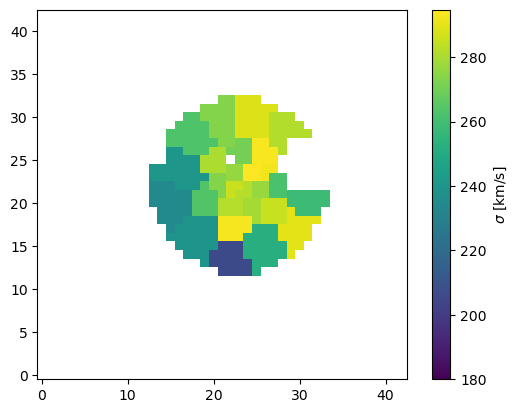

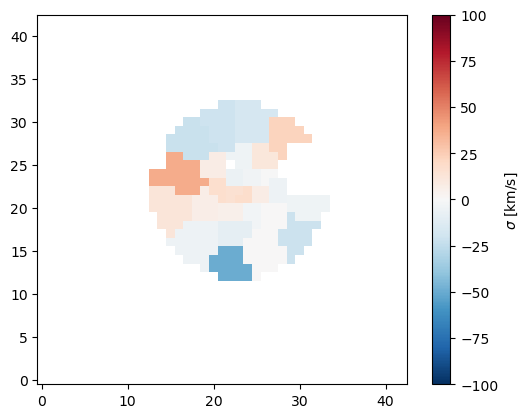

In [50]:
VD_2d, dVD_2d, V_2d, dV_2d = kinematics_map(dir, name+'_targetSN_{}'.format(snr_2), radius_in_pixels=21,
                                            VD_name='targetSN_{}_excluding_bins'.format(snr_2), vd_val=1000)

plt.imshow(VD_2d, origin='lower', cmap='viridis', vmin=180)
cbar = plt.colorbar()
cbar.set_label(r'$\sigma$ [km/s]')
plt.show()

plt.imshow(V_2d - 180, origin='lower', cmap='RdBu_r', vmax=100, vmin=-100) #, vmin=180)
cbar = plt.colorbar()
cbar.set_label(r'$\sigma$ [km/s]')
plt.show()

In [51]:
VD_2d.shape

(43, 43)

### Check systematics

In [52]:
wavelength_list = [['rng_1', 0.34, 0.43], ['rng_2', 0.335, 0.425], ['rng_3', 0.33, 0.42]]
deg_list = [2, 3, 4]
global_temp_list = [global_temp1, global_temp2, global_temp3]
quasar_list = [quasar_spectrum_A, quasar_spectrum_B, quasar_spectrum_C]

In [55]:
voronoi_binning_data = fits.getdata(dir +'voronoi_binning_' + name + '_targetSN_{}'.format(snr_1) + '_data.fits')

for w in wavelength_list:
    wv_min, wv_max = w[1], w[2]
    for d in deg_list:
        deg = d
        for i, gt in enumerate(global_temp_list):
            global_tmp = gt
            for j, qsp in enumerate(quasar_list):
                quasar_spec = qsp
                qsp_name = chr(j+65)
                print('noise notebook', noise)
                vd_name = 'wave_{}_deg_{}_global_temp_{}_quasar_sp_{}_SN_{}'.format(w[0], deg, i+1, qsp_name, snr_1)
                get_velocity_dispersion_deredshift(degree=deg,
                                   spectrum_aperture=spectrum_aperture,
                                   voronoi_binning_data=voronoi_binning_data,
                                   velscale_ratio=velscale_ratio,
                                   z=z, noise=noise, FWHM=FWHM_gal,
                                   FWHM_tem_xshooter=FWHM_tem_xshooter,
                                   dir=dir, libary_dir=libary_dir,
                                   global_temp=global_tmp,
                                   quasar_spectrum=quasar_spec,
                                   wave_min=wv_min, wave_max=wv_max,
                                   T_exp=T_exp, VD_name=vd_name,
                                   plot=False, verbose=False, quiet=True)
            
                ## just to check
                raise('')

                print('VD_wave_{}_deg_{}_global_temp_{}_quasar_sp_{}'.format(w[0], deg, i+1, qsp_name))
                ppxf_kinematics_RXJ1131_getGlobal_lens_deredshift(libary_dir,
                                                      degree=deg,
                                                      spectrum_aperture=spectrum_aperture,
                                                      wave_min=wv_min, wave_max=wv_max,
                                                      velscale_ratio=velscale_ratio,
                                                      z=z, noise=noise,
                                                      templates_name='xshooter',
                                                      FWHM=FWHM_gal,
                                                      FWHM_tem=FWHM_tem_xshooter,
                                                      quasar_spectrum=quasar_spec,
                                                      plot=True, global_template_lens=global_tmp,
                                                spectrum_perpixel=voronoi_binning_data[0])
                
                plt.show()
                break

noise notebook [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
shapes (5215,) (302,)
noise 1 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

shapes (5215,) (5215,)
noise 1 [0.00278371 0.0027839  0.00278409 ... 0.00383001 0.00382892 0.00305469]
noise 2 [0.00278371 0.0027839  0.00278409 ... 0.00383001 0.00382892 0.00305469]
shapes (5215,) (302,)
noise 1 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

shapes (5215,) (302,)
noise 1 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
noise 2 [1. 1. 1. ... 1. 1. 1.]
[nan] 9.3548957180

[nan] 0.0006972215431065488
shapes (5215,) (5215,)
noise 1 [0.02622408 0.02622421 0.02622438 ... 0.02662959 0.02662878 0.02640495]
noise 2 [0.02622408 0.02622421 0.02622438 ... 0.02662959 0.02662878 0.02640495]
shapes (5215,) (302,)
noise 1 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

[nan] 0.00015841617609052298
shapes (5215,) (5215,)
noise 1 [0.01216696 0.01216728 0.01216761 ... 0.01307536 0.01307469 0.01258635]
noise 2 [0.01216696 0.01216728 0.01216761 ... 0.01307536 0.01307469 0.01258635]
shapes (5215,) (302,)
noise 1 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 

TypeError: exceptions must derive from BaseException

<Figure size 640x480 with 0 Axes>